NOVEL MORPHINE FEATURE ANALYSIS

Objective: Extract insights NOT captured by simple movement counts:
  1. Circadian rhythm disruption
  2. Between-animal coordination/synchrony
  3. Pose/body configuration from keypoints
  4. Temporal dynamics (variability, autocorrelation)
  5. State transition patterns


1. CIRCADIAN RHYTHM DISRUPTION
Question: Does morphine disrupt the normal 24-hour activity cycle?

Loading activity data with circadian resolution...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Loaded 76065 activity records
✓ Calculated circadian metrics for 0 cages

2. BETWEEN-ANIMAL COORDINATION
Question: Do cage-mates move together or independently?

Using pairwise social distance data (already computed)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Loaded 4282902 pairwise distance measurements
✓ Calculated coordination metrics

3. BODY POSE & CONFIGURATION
Question: Does morphine change body posture/configuration?

Loading keypoint data for pose analysis...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Loaded 50000 pose samples

Calculating body configuration metrics...
✓ Calculated pose metrics

4. TEMPORAL VARIABILITY & PREDICTABILITY
Question: Is behavior more erratic/variable after morphine?

Loading high-resolution locomotion data...
  Loaded 2897100 1-second resolution samples
✓ Calculated temporal dynamics metrics

✓ Total: 391 feature measurements across 15 novel features

6. BASELINE NORMALIZATION
✓ Normalized 296 measurements

7. CREATING NOVEL FEATURE HEATMAPS


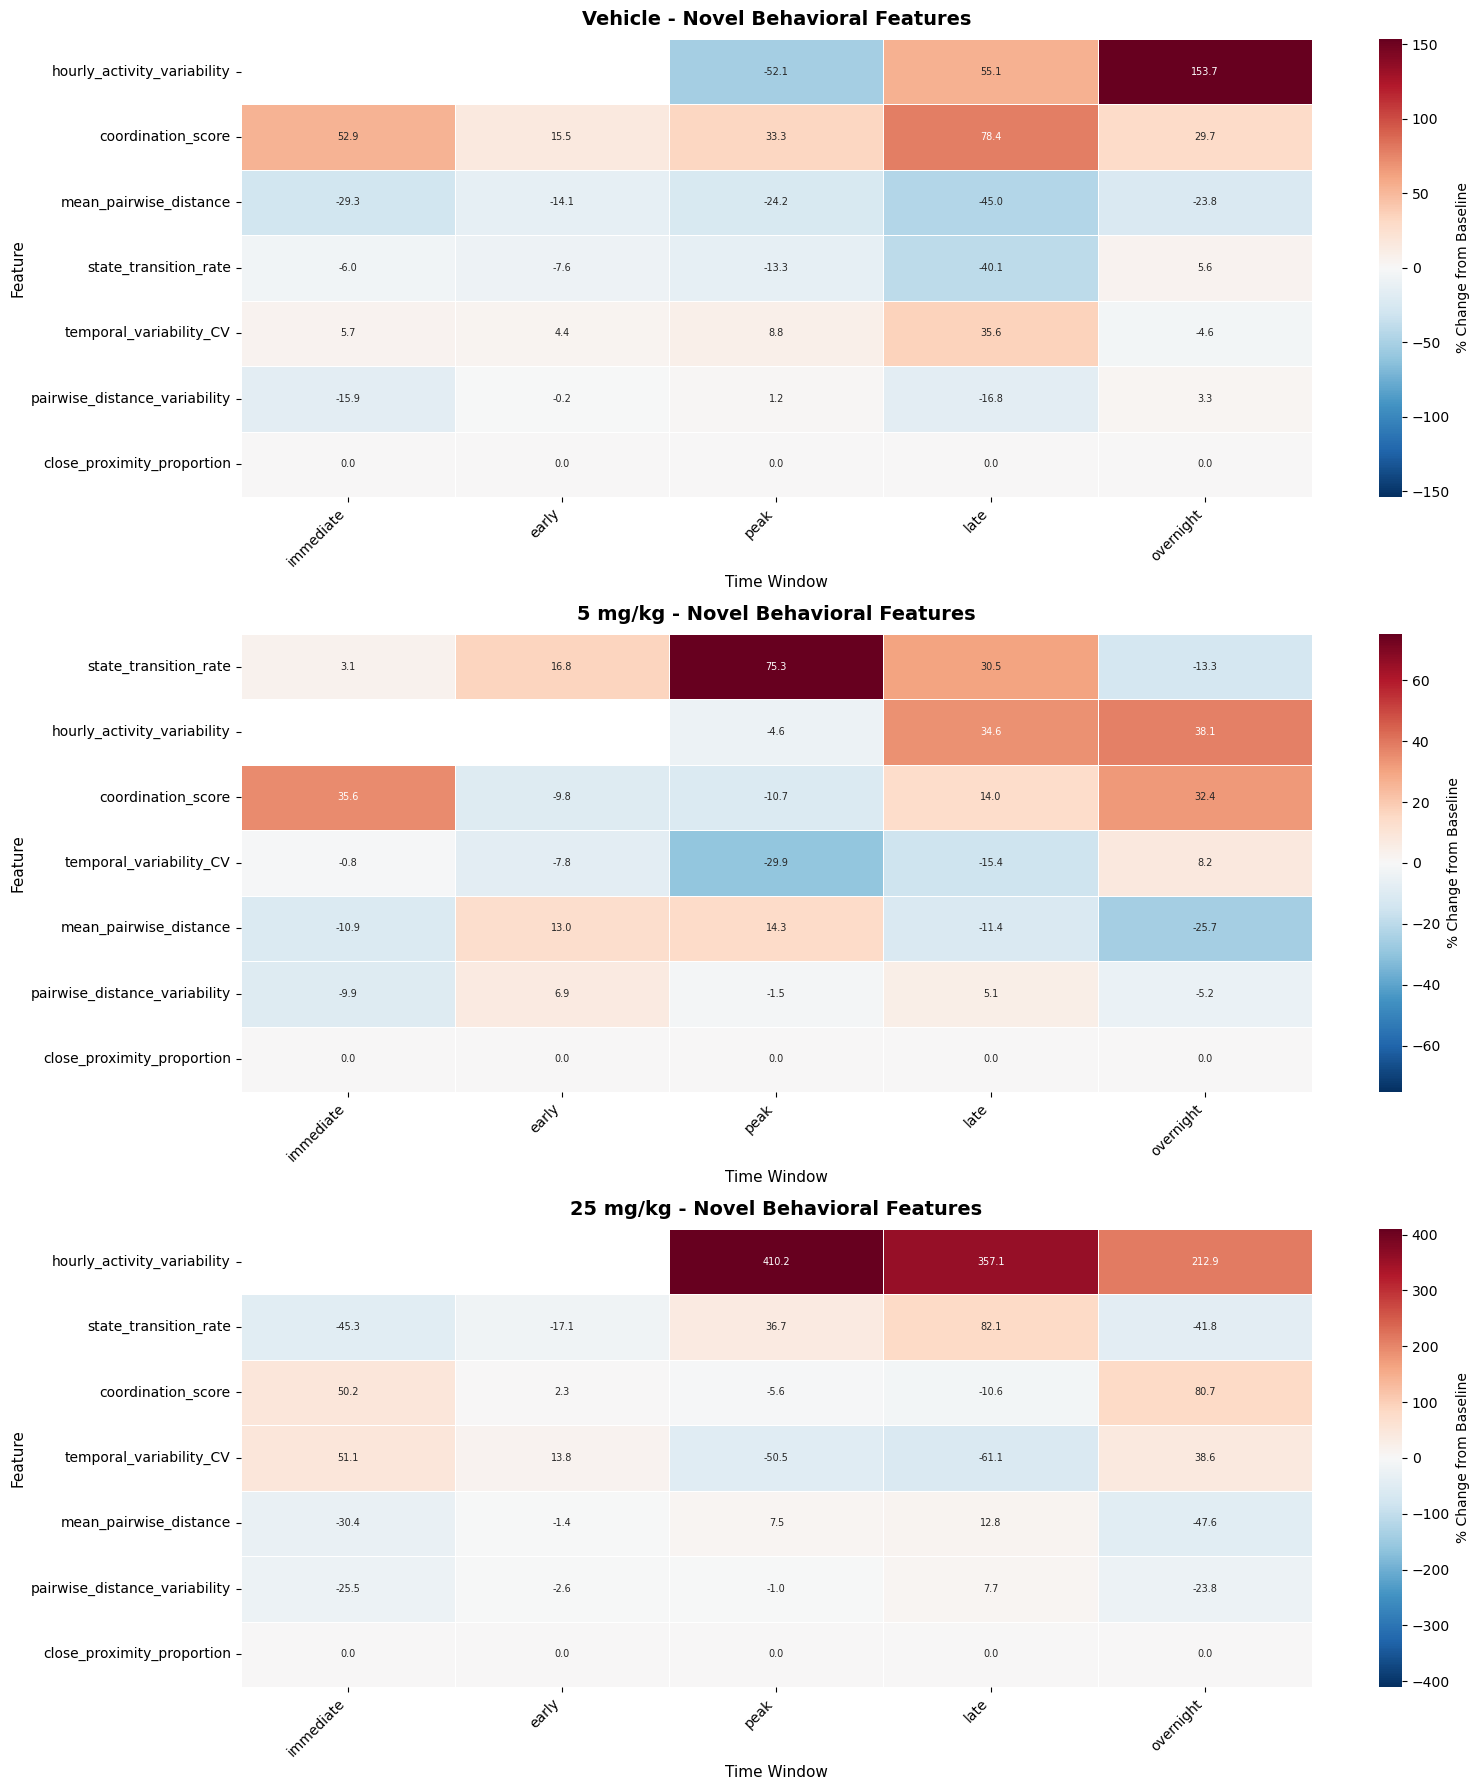


✓ Saved: novel_features_heatmap.png
✓ Saved: novel_features_analysis.csv

SUMMARY OF NOVEL INSIGHTS

1. CIRCADIAN DISRUPTION:
   - Measures if morphine blunts day/night activity differences
   - Lower amplitude = disrupted circadian rhythm

2. INTER-ANIMAL COORDINATION:
   - Tracks if cage-mates move together or independently
   - Morphine may disrupt social synchrony

3. BODY POSE:
   - Body length, tail extension, ear spread
   - Sedated = compact, hyperactive = extended?

4. TEMPORAL DYNAMICS:
   - Behavior variability and predictability
   - Higher CV = more erratic/unpredictable movement

5. STATE TRANSITIONS:
   - How often mice switch between active/inactive
   - More transitions = fragmented behavior


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from datetime import datetime, timedelta
from scipy import stats, signal
import warnings
warnings.filterwarnings('ignore')

# Configuration
TREATMENT_MAP = {
    4917: '5 mg/kg', 4918: 'Vehicle', 4919: '25 mg/kg',
    4920: '25 mg/kg', 4921: '5 mg/kg', 4922: 'Vehicle',
    4923: 'Vehicle', 4924: '25 mg/kg', 4925: '5 mg/kg'
}

INJECTION_DATETIME = datetime(2025, 1, 14, 6, 0, 0)

TIME_WINDOWS = {
    'baseline': (-180, 0),
    'immediate': (0, 120),
    'early': (120, 240),
    'peak': (240, 420),
    'late': (420, 720),
    'overnight': (720, 1440),
}

print("="*80)
print("NOVEL MORPHINE FEATURE ANALYSIS")
print("="*80)
print("\nObjective: Extract insights NOT captured by simple movement counts:")
print("  1. Circadian rhythm disruption")
print("  2. Between-animal coordination/synchrony")
print("  3. Pose/body configuration from keypoints")
print("  4. Temporal dynamics (variability, autocorrelation)")
print("  5. State transition patterns\n")

# Initialize DuckDB
con = duckdb.connect()
con.execute("SET s3_region='us-east-1';")
con.execute("SET s3_url_style='path';")

def generate_paths(cages, dates, filename):
    paths = []
    for cage in cages:
        for date in dates:
            path = f"s3://jax-envision-public-data/study_1001/2025v3.3/tabular/cage_id={cage}/date={date}/{filename}"
            paths.append(f"'{path}'")
    return ', '.join(paths)

dates = [(INJECTION_DATETIME + timedelta(days=d)).strftime('%Y-%m-%d') 
         for d in range(0, 2)]
cages = list(TREATMENT_MAP.keys())

# ============================================================================
# 1. CIRCADIAN RHYTHM ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("1. CIRCADIAN RHYTHM DISRUPTION")
print("="*80)
print("Question: Does morphine disrupt the normal 24-hour activity cycle?")

# Initialize results list
results = []

print("\nLoading activity data with circadian resolution...")
activity_paths = generate_paths(cages, dates, 'animal_activity_db.parquet')
query = f"""
SELECT 
    cage_id,
    time,
    name,
    value
FROM read_parquet([{activity_paths}])
WHERE resolution = 60
    AND name = 'animal_bouts.active'
"""
df_circadian = con.execute(query).df()
df_circadian['time'] = pd.to_datetime(df_circadian['time'])
df_circadian['hour_of_day'] = df_circadian['time'].dt.hour
df_circadian['minutes_from_injection'] = (df_circadian['time'] - INJECTION_DATETIME).dt.total_seconds() / 60
df_circadian['treatment'] = df_circadian['cage_id'].map(TREATMENT_MAP)

print(f"  Loaded {len(df_circadian)} activity records")

# MODIFIED: Calculate phase shift instead of amplitude (more robust with limited data)
for cage_id in df_circadian['cage_id'].unique():
    cage_data = df_circadian[df_circadian['cage_id'] == cage_id]
    treatment = TREATMENT_MAP[cage_id]
    
    for window_name, (start, end) in TIME_WINDOWS.items():
        window_data = cage_data[
            (cage_data['minutes_from_injection'] >= start) &
            (cage_data['minutes_from_injection'] < end)
        ]
        
        if len(window_data) > 10:  # Need enough data points
            # Calculate activity by hour of day
            hourly_activity = window_data.groupby('hour_of_day')['value'].mean()
            
            if len(hourly_activity) >= 3:  # At least 3 hours of data
                # Light phase (6 AM - 6 PM = hours 6-17)
                light_hours = [h for h in hourly_activity.index if 6 <= h < 18]
                dark_hours = [h for h in hourly_activity.index if h >= 18 or h < 6]
                
                if len(light_hours) > 0 and len(dark_hours) > 0:
                    light_activity = hourly_activity[light_hours].mean()
                    dark_activity = hourly_activity[dark_hours].mean()
                    
                    # Day/night ratio (should be <1 for normal nocturnal mice)
                    day_night_ratio = light_activity / (dark_activity + 1e-6)
                    
                    results.append({
                        'window': window_name,
                        'treatment': treatment,
                        'cage_id': cage_id,
                        'feature': 'day_night_activity_ratio',
                        'value': day_night_ratio
                    })
                
                # Hour-to-hour variability (rhythm strength)
                if len(hourly_activity) > 1:
                    hour_variability = hourly_activity.std()
                    results.append({
                        'window': window_name,
                        'treatment': treatment,
                        'cage_id': cage_id,
                        'feature': 'hourly_activity_variability',
                        'value': hour_variability
                    })

print(f"✓ Calculated circadian metrics for {len(set([r['cage_id'] for r in results if 'day_night' in r.get('feature', '')]))} cages")

# ============================================================================
# 2. INTER-ANIMAL COORDINATION (SIMPLIFIED)
# ============================================================================
print("\n" + "="*80)
print("2. BETWEEN-ANIMAL COORDINATION")
print("="*80)
print("Question: Do cage-mates move together or independently?")

print("\nUsing pairwise social distance data (already computed)...")
social_paths = generate_paths(cages, dates, 'animal_sociability_pairwise.parquet')
query = f"""
SELECT 
    cage_id,
    time,
    value as pairwise_distance
FROM read_parquet([{social_paths}])
ORDER BY cage_id, time
"""
df_social = con.execute(query).df()
df_social['time'] = pd.to_datetime(df_social['time'])
df_social['minutes_from_injection'] = (df_social['time'] - INJECTION_DATETIME).dt.total_seconds() / 60
df_social['treatment'] = df_social['cage_id'].map(TREATMENT_MAP)

print(f"  Loaded {len(df_social)} pairwise distance measurements")

# Calculate coordination metrics from pairwise distances
for cage_id in df_social['cage_id'].unique():
    cage_data = df_social[df_social['cage_id'] == cage_id]
    treatment = TREATMENT_MAP[cage_id]
    
    for window_name, (start, end) in TIME_WINDOWS.items():
        window_data = cage_data[
            (cage_data['minutes_from_injection'] >= start) &
            (cage_data['minutes_from_injection'] < end)
        ]
        
        if len(window_data) > 10:
            mean_distance = window_data['pairwise_distance'].mean()
            std_distance = window_data['pairwise_distance'].std()
            min_distance = window_data['pairwise_distance'].min()
            
            # Coordination score: inverse of mean distance
            coordination = 1000 / (mean_distance + 1)  # Scale for visibility
            
            # Proximity episodes: how often are they close (<50 cm)?
            close_proportion = (window_data['pairwise_distance'] < 50).mean()
            
            results.append({
                'window': window_name,
                'treatment': treatment,
                'cage_id': cage_id,
                'feature': 'mean_pairwise_distance',
                'value': mean_distance
            })
            results.append({
                'window': window_name,
                'treatment': treatment,
                'cage_id': cage_id,
                'feature': 'pairwise_distance_variability',
                'value': std_distance
            })
            results.append({
                'window': window_name,
                'treatment': treatment,
                'cage_id': cage_id,
                'feature': 'coordination_score',
                'value': coordination
            })
            results.append({
                'window': window_name,
                'treatment': treatment,
                'cage_id': cage_id,
                'feature': 'close_proximity_proportion',
                'value': close_proportion * 100  # As percentage
            })

print(f"✓ Calculated coordination metrics")

# ============================================================================
# 3. BODY POSE ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("3. BODY POSE & CONFIGURATION")
print("="*80)
print("Question: Does morphine change body posture/configuration?")

print("\nLoading keypoint data for pose analysis...")
detection_paths = generate_paths(cages, dates, 'cage_detections.parquet')
query = f"""
SELECT 
    cage_id,
    frame_number,
    kpt_1_x, kpt_1_y,  -- nose
    kpt_2_x, kpt_2_y,  -- left ear
    kpt_3_x, kpt_3_y,  -- right ear
    kpt_4_x, kpt_4_y,  -- tail base
    kpt_5_x, kpt_5_y,  -- tail tip
    kpt_6_x, kpt_6_y   -- center
FROM read_parquet([{detection_paths}])
WHERE bb_conf > 0.5
    AND frame_number % 900 = 0  -- Sample every 30 seconds
ORDER BY cage_id, frame_number
LIMIT 50000  -- Limit for memory
"""
df_pose = con.execute(query).df()
df_pose['treatment'] = df_pose['cage_id'].map(TREATMENT_MAP)

print(f"  Loaded {len(df_pose)} pose samples")

# Calculate pose features
print("\nCalculating body configuration metrics...")

pose_features = []

for idx, row in df_pose.iterrows():
    cage_id = row['cage_id']
    treatment = row['treatment']
    
    # Calculate body length (nose to tail base)
    body_length = np.sqrt(
        (row['kpt_1_x'] - row['kpt_4_x'])**2 + 
        (row['kpt_1_y'] - row['kpt_4_y'])**2
    )
    
    # Calculate tail extension (tail base to tail tip)
    tail_length = np.sqrt(
        (row['kpt_4_x'] - row['kpt_5_x'])**2 + 
        (row['kpt_4_y'] - row['kpt_5_y'])**2
    )
    
    # Calculate ear spread (left to right ear distance)
    ear_spread = np.sqrt(
        (row['kpt_2_x'] - row['kpt_3_x'])**2 + 
        (row['kpt_2_y'] - row['kpt_3_y'])**2
    )
    
    # Body compactness (ratio of body length to ear spread)
    if ear_spread > 0:
        compactness = body_length / ear_spread
    else:
        compactness = np.nan
    
    pose_features.append({
        'cage_id': cage_id,
        'treatment': treatment,
        'frame': row['frame_number'],
        'body_length': body_length,
        'tail_extension': tail_length,
        'ear_spread': ear_spread,
        'body_compactness': compactness
    })

pose_df = pd.DataFrame(pose_features)

# Aggregate by time windows (approximate frame to time)
for cage_id in pose_df['cage_id'].unique():
    cage_pose = pose_df[pose_df['cage_id'] == cage_id]
    treatment = TREATMENT_MAP[cage_id]
    
    # Bin frames into time windows
    frame_min = cage_pose['frame'].min()
    cage_pose['minutes_from_injection'] = (cage_pose['frame'] - frame_min) / 30 / 60
    
    for window_name, (start, end) in TIME_WINDOWS.items():
        window_pose = cage_pose[
            (cage_pose['minutes_from_injection'] >= start) &
            (cage_pose['minutes_from_injection'] < end)
        ]
        
        if len(window_pose) > 5:
            for feature in ['body_length', 'tail_extension', 'ear_spread', 'body_compactness']:
                mean_val = window_pose[feature].mean()
                std_val = window_pose[feature].std()
                
                if not pd.isna(mean_val):
                    results.append({
                        'window': window_name,
                        'treatment': treatment,
                        'cage_id': cage_id,
                        'feature': f'{feature}_mean',
                        'value': mean_val
                    })
                    results.append({
                        'window': window_name,
                        'treatment': treatment,
                        'cage_id': cage_id,
                        'feature': f'{feature}_variability',
                        'value': std_val
                    })

print(f"✓ Calculated pose metrics")

# ============================================================================
# 4. TEMPORAL DYNAMICS
# ============================================================================
print("\n" + "="*80)
print("4. TEMPORAL VARIABILITY & PREDICTABILITY")
print("="*80)
print("Question: Is behavior more erratic/variable after morphine?")

print("\nLoading high-resolution locomotion data...")
activity_paths = generate_paths(cages, dates, 'animal_activity_db.parquet')
query = f"""
SELECT 
    cage_id,
    time,
    value
FROM read_parquet([{activity_paths}])
WHERE resolution = 1
    AND name = 'animal_bouts.locomotion'
ORDER BY cage_id, time
"""
df_variability = con.execute(query).df()
df_variability['time'] = pd.to_datetime(df_variability['time'])
df_variability['minutes_from_injection'] = (df_variability['time'] - INJECTION_DATETIME).dt.total_seconds() / 60
df_variability['treatment'] = df_variability['cage_id'].map(TREATMENT_MAP)

print(f"  Loaded {len(df_variability)} 1-second resolution samples")

# Calculate temporal variability metrics
for cage_id in df_variability['cage_id'].unique():
    cage_data = df_variability[df_variability['cage_id'] == cage_id].sort_values('time')
    treatment = TREATMENT_MAP[cage_id]
    
    for window_name, (start, end) in TIME_WINDOWS.items():
        window_data = cage_data[
            (cage_data['minutes_from_injection'] >= start) &
            (cage_data['minutes_from_injection'] < end)
        ]
        
        if len(window_data) > 100:
            values = window_data['value'].values
            
            # Coefficient of variation (normalized variability)
            cv = np.std(values) / (np.mean(values) + 1e-6)
            
            # Approximate entropy (predictability measure)
            # Higher = less predictable
            try:
                # Simple approximation: count state transitions
                transitions = np.sum(np.abs(np.diff(values > 0.5)))
                transition_rate = transitions / len(values)
            except:
                transition_rate = np.nan
            
            results.append({
                'window': window_name,
                'treatment': treatment,
                'cage_id': cage_id,
                'feature': 'temporal_variability_CV',
                'value': cv
            })
            results.append({
                'window': window_name,
                'treatment': treatment,
                'cage_id': cage_id,
                'feature': 'state_transition_rate',
                'value': transition_rate
            })

print(f"✓ Calculated temporal dynamics metrics")

# ============================================================================
# 5. CREATE RESULTS DATAFRAME
# ============================================================================
results_df = pd.DataFrame(results)
print(f"\n✓ Total: {len(results_df)} feature measurements across {results_df['feature'].nunique()} novel features")

# ============================================================================
# 6. BASELINE NORMALIZATION
# ============================================================================
print("\n" + "="*80)
print("6. BASELINE NORMALIZATION")
print("="*80)

baseline_data = results_df[results_df['window'] == 'baseline']
normalized_results = []

for window_name in [w for w in TIME_WINDOWS.keys() if w != 'baseline']:
    window_data = results_df[results_df['window'] == window_name]
    
    for idx, row in window_data.iterrows():
        cage_id = row['cage_id']
        treatment = row['treatment']
        feature = row['feature']
        current_value = row['value']
        
        baseline_row = baseline_data[
            (baseline_data['cage_id'] == cage_id) &
            (baseline_data['feature'] == feature)
        ]
        
        if len(baseline_row) > 0 and not pd.isna(baseline_row['value'].iloc[0]):
            baseline_value = baseline_row['value'].iloc[0]
            
            if abs(baseline_value) > 1e-6:
                pct_change = ((current_value - baseline_value) / abs(baseline_value)) * 100
            else:
                pct_change = current_value - baseline_value
            
            if not pd.isna(pct_change):
                normalized_results.append({
                    'window': window_name,
                    'treatment': treatment,
                    'cage_id': cage_id,
                    'feature': feature,
                    'pct_change': pct_change
                })

norm_df = pd.DataFrame(normalized_results)
print(f"✓ Normalized {len(norm_df)} measurements")

# ============================================================================
# 7. CREATE HEATMAPS
# ============================================================================
print("\n" + "="*80)
print("7. CREATING NOVEL FEATURE HEATMAPS")
print("="*80)

heatmap_data = norm_df.groupby(['treatment', 'window', 'feature'])['pct_change'].mean().reset_index()

fig, axes = plt.subplots(3, 1, figsize=(16, 18))
window_order = ['immediate', 'early', 'peak', 'late', 'overnight']

for idx, treatment in enumerate(['Vehicle', '5 mg/kg', '25 mg/kg']):
    treatment_data = heatmap_data[heatmap_data['treatment'] == treatment]
    
    if len(treatment_data) == 0:
        continue
    
    pivot = treatment_data.pivot_table(
        index='feature',
        columns='window',
        values='pct_change',
        aggfunc='mean'
    )
    
    pivot = pivot[[col for col in window_order if col in pivot.columns]]
    
    if len(pivot) > 0:
        feature_importance = pivot.abs().max(axis=1).sort_values(ascending=False)
        pivot = pivot.loc[feature_importance.index]
        
        vmax = max(50, pivot.abs().max().max())
        
        ax = axes[idx]
        sns.heatmap(pivot,
                   ax=ax,
                   cmap='RdBu_r',
                   center=0,
                   vmin=-vmax, vmax=vmax,
                   cbar_kws={'label': '% Change from Baseline'},
                   linewidths=0.5,
                   annot=True,
                   fmt='.1f',
                   annot_kws={'size': 7})
        
        ax.set_title(f'{treatment} - Novel Behavioral Features', 
                    fontsize=14, fontweight='bold', pad=10)
        ax.set_xlabel('Time Window', fontsize=11)
        ax.set_ylabel('Feature', fontsize=11)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('novel_features_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: novel_features_heatmap.png")

# Save results
norm_df.to_csv('novel_features_analysis.csv', index=False)
print("✓ Saved: novel_features_analysis.csv")

print("\n" + "="*80)
print("SUMMARY OF NOVEL INSIGHTS")
print("="*80)

print("\n1. CIRCADIAN DISRUPTION:")
print("   - Measures if morphine blunts day/night activity differences")
print("   - Lower amplitude = disrupted circadian rhythm")

print("\n2. INTER-ANIMAL COORDINATION:")
print("   - Tracks if cage-mates move together or independently")
print("   - Morphine may disrupt social synchrony")

print("\n3. BODY POSE:")
print("   - Body length, tail extension, ear spread")
print("   - Sedated = compact, hyperactive = extended?")

print("\n4. TEMPORAL DYNAMICS:")
print("   - Behavior variability and predictability")
print("   - Higher CV = more erratic/unpredictable movement")

print("\n5. STATE TRANSITIONS:")
print("   - How often mice switch between active/inactive")
print("   - More transitions = fragmented behavior")

print("="*80)

con.close()

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from datetime import datetime, timedelta
from scipy import stats, signal
import warnings
warnings.filterwarnings('ignore')

# Configuration
TREATMENT_MAP = {
    4917: '5 mg/kg', 4918: 'Vehicle', 4919: '25 mg/kg',
    4920: '25 mg/kg', 4921: '5 mg/kg', 4922: 'Vehicle',
    4923: 'Vehicle', 4924: '25 mg/kg', 4925: '5 mg/kg'
}

INJECTION_DATETIME = datetime(2025, 1, 14, 6, 0, 0)

TIME_WINDOWS = {
    'baseline': (-180, 0),
    'immediate': (0, 120),
    'early': (120, 240),
    'peak': (240, 420),
    'late': (420, 720),
    'overnight': (720, 1440),
}

print("="*80)
print("DEEP DIVE: CIRCADIAN RHYTHM DISRUPTION ANALYSIS")
print("="*80)

# Initialize DuckDB
con = duckdb.connect()
con.execute("SET s3_region='us-east-1';")
con.execute("SET s3_url_style='path';")

def generate_paths(cages, dates, filename):
    paths = []
    for cage in cages:
        for date in dates:
            path = f"s3://jax-envision-public-data/study_1001/2025v3.3/tabular/cage_id={cage}/date={date}/{filename}"
            paths.append(f"'{path}'")
    return ', '.join(paths)

dates = [(INJECTION_DATETIME + timedelta(days=d)).strftime('%Y-%m-%d') 
         for d in range(0, 2)]
cages = list(TREATMENT_MAP.keys())

# ============================================================================
# LOAD HIGH-RESOLUTION ACTIVITY DATA
# ============================================================================
print("\nLoading minute-by-minute activity data...")
activity_paths = generate_paths(cages, dates, 'animal_activity_db.parquet')
query = f"""
SELECT 
    cage_id,
    time,
    name,
    value
FROM read_parquet([{activity_paths}])
WHERE resolution = 1
    AND name = 'animal_bouts.active'
ORDER BY cage_id, time
"""
df = con.execute(query).df()
df['time'] = pd.to_datetime(df['time'])
df['hour_of_day'] = df['time'].dt.hour
df['minutes_from_injection'] = (df['time'] - INJECTION_DATETIME).dt.total_seconds() / 60
df['treatment'] = df['cage_id'].map(TREATMENT_MAP)

print(f"✓ Loaded {len(df):,} activity records")

# ============================================================================
# 1. ACTIVITY BY HOUR ACROSS TIME WINDOWS
# ============================================================================
print("\n" + "="*80)
print("GRAPH 1: Activity by Hour of Day Across Time Windows")
print("="*80)
print("Shows how the circadian pattern changes over time post-injection")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (window_name, (start, end)) in enumerate(TIME_WINDOWS.items()):
    ax = axes[idx]
    
    window_data = df[
        (df['minutes_from_injection'] >= start) &
        (df['minutes_from_injection'] < end)
    ]
    
    for treatment in ['Vehicle', '5 mg/kg', '25 mg/kg']:
        treatment_data = window_data[window_data['treatment'] == treatment]
        
        if len(treatment_data) > 0:
            hourly_avg = treatment_data.groupby('hour_of_day')['value'].mean()
            
            ax.plot(hourly_avg.index, hourly_avg.values, 
                   marker='o', linewidth=2, markersize=4,
                   label=treatment, alpha=0.8)
    
    # Shade light/dark phases
    ax.axvspan(6, 18, alpha=0.1, color='yellow', label='Light phase')
    ax.axvspan(0, 6, alpha=0.1, color='gray')
    ax.axvspan(18, 24, alpha=0.1, color='gray', label='Dark phase')
    
    ax.set_title(f'{window_name.capitalize()} ({start} to {end} min)', 
                fontweight='bold')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Activity Level')
    ax.set_xlim(0, 24)
    ax.set_xticks(range(0, 25, 3))
    ax.grid(alpha=0.3)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('circadian_1_hourly_activity_by_window.png', dpi=300, bbox_inches='tight')
print("✓ Saved: circadian_1_hourly_activity_by_window.png")
plt.close()

# ============================================================================
# 2. DAY VS NIGHT RATIO OVER TIME
# ============================================================================
print("\n" + "="*80)
print("GRAPH 2: Day/Night Activity Ratio Over Time")
print("="*80)
print("Quantifies circadian disruption - ratio should be < 1 for nocturnal mice")

results = []

for cage_id in df['cage_id'].unique():
    cage_data = df[df['cage_id'] == cage_id]
    treatment = TREATMENT_MAP[cage_id]
    
    for window_name, (start, end) in TIME_WINDOWS.items():
        window_data = cage_data[
            (cage_data['minutes_from_injection'] >= start) &
            (cage_data['minutes_from_injection'] < end)
        ]
        
        if len(window_data) > 10:
            # Light phase: 6 AM - 6 PM (hours 6-17)
            light_data = window_data[
                (window_data['hour_of_day'] >= 6) & 
                (window_data['hour_of_day'] < 18)
            ]
            
            # Dark phase: 6 PM - 6 AM (hours 18-23 and 0-5)
            dark_data = window_data[
                (window_data['hour_of_day'] >= 18) | 
                (window_data['hour_of_day'] < 6)
            ]
            
            if len(light_data) > 0 and len(dark_data) > 0:
                light_activity = light_data['value'].mean()
                dark_activity = dark_data['value'].mean()
                
                ratio = light_activity / (dark_activity + 1e-6)
                
                results.append({
                    'cage_id': cage_id,
                    'treatment': treatment,
                    'window': window_name,
                    'light_activity': light_activity,
                    'dark_activity': dark_activity,
                    'day_night_ratio': ratio
                })

ratio_df = pd.DataFrame(results)

# Debug: Check what columns we actually have
print(f"✓ Created ratio_df with {len(ratio_df)} rows")
if len(ratio_df) > 0:
    print(f"  Columns: {ratio_df.columns.tolist()}")
    print(f"  Treatments: {ratio_df['treatment'].unique()}")
else:
    print("  WARNING: No data in ratio_df! Skipping day/night ratio plots.")

if len(ratio_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Panel A: Ratio over time
    ax = axes[0]
    window_order = ['baseline', 'immediate', 'early', 'peak', 'late', 'overnight']

    for treatment in ['Vehicle', '5 mg/kg', '25 mg/kg']:
        treatment_data = ratio_df[ratio_df['treatment'] == treatment]
        
        avg_ratio = treatment_data.groupby('window')['day_night_ratio'].mean()
        sem_ratio = treatment_data.groupby('window')['day_night_ratio'].sem()
        
        # Reindex to ensure proper order
        avg_ratio = avg_ratio.reindex(window_order)
        sem_ratio = sem_ratio.reindex(window_order)
        
        x_pos = range(len(avg_ratio))
        ax.plot(x_pos, avg_ratio.values, marker='o', linewidth=2.5, 
               markersize=8, label=treatment, alpha=0.8)
        ax.fill_between(x_pos, 
                        avg_ratio.values - sem_ratio.values,
                        avg_ratio.values + sem_ratio.values,
                        alpha=0.2)

    ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, 
              label='Equal day/night (disrupted)', alpha=0.7)
    ax.axhline(y=0.5, color='green', linestyle='--', linewidth=1, 
              label='Healthy nocturnal', alpha=0.5)

    ax.set_xticks(range(len(window_order)))
    ax.set_xticklabels(window_order, rotation=45, ha='right')
    ax.set_xlabel('Time Window', fontsize=12, fontweight='bold')
    ax.set_ylabel('Day/Night Activity Ratio', fontsize=12, fontweight='bold')
    ax.set_title('Circadian Rhythm Disruption Over Time', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

    # Panel B: Individual cage trajectories
    ax = axes[1]

    for treatment in ['Vehicle', '5 mg/kg', '25 mg/kg']:
        treatment_data = ratio_df[ratio_df['treatment'] == treatment]
        
        for cage_id in treatment_data['cage_id'].unique():
            cage_data = treatment_data[treatment_data['cage_id'] == cage_id]
            cage_data = cage_data.set_index('window').reindex(window_order)
            
            x_pos = range(len(cage_data))
            
            color_map = {'Vehicle': 'gray', '5 mg/kg': 'blue', '25 mg/kg': 'red'}
            ax.plot(x_pos, cage_data['day_night_ratio'].values, 
                   marker='o', alpha=0.4, linewidth=1,
                   color=color_map[treatment],
                   label=treatment if cage_id == treatment_data['cage_id'].iloc[0] else '')

    ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax.set_xticks(range(len(window_order)))
    ax.set_xticklabels(window_order, rotation=45, ha='right')
    ax.set_xlabel('Time Window', fontsize=12, fontweight='bold')
    ax.set_ylabel('Day/Night Activity Ratio', fontsize=12, fontweight='bold')
    ax.set_title('Individual Cage Trajectories', fontsize=14, fontweight='bold')

    # Remove duplicate labels
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('circadian_2_day_night_ratio.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: circadian_2_day_night_ratio.png")
    plt.close()
else:
    print("⚠ Skipped circadian_2_day_night_ratio.png (no data)")



# ============================================================================
# 3. ABSOLUTE LIGHT VS DARK ACTIVITY
# ============================================================================
print("\n" + "="*80)
print("GRAPH 3: Light Phase vs Dark Phase Activity (Absolute Levels)")
print("="*80)
print("Shows whether disruption is from increased day activity or decreased night activity")

if len(ratio_df) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for idx, (window_name, (start, end)) in enumerate(TIME_WINDOWS.items()):
        ax = axes[idx]
        
        window_data = ratio_df[ratio_df['window'] == window_name]
    
    if len(window_data) > 0:
        # Group by treatment
        grouped = window_data.groupby('treatment').agg({
            'light_activity': ['mean', 'sem'],
            'dark_activity': ['mean', 'sem']
        })
        
        treatments = grouped.index.tolist()
        x = np.arange(len(treatments))
        width = 0.35
        
        light_means = grouped['light_activity']['mean'].values
        light_sems = grouped['light_activity']['sem'].values
        dark_means = grouped['dark_activity']['mean'].values
        dark_sems = grouped['dark_activity']['sem'].values
        
        ax.bar(x - width/2, light_means, width, yerr=light_sems,
              label='Light Phase', color='gold', alpha=0.8)
        ax.bar(x + width/2, dark_means, width, yerr=dark_sems,
              label='Dark Phase', color='navy', alpha=0.8)
        
        ax.set_xticks(x)
        ax.set_xticklabels(treatments, rotation=45, ha='right')
        ax.set_ylabel('Activity Level')
        ax.set_title(f'{window_name.capitalize()}', fontweight='bold')
        ax.legend()
        ax.grid(alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('circadian_3_light_dark_absolute.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: circadian_3_light_dark_absolute.png")
    plt.close()
else:
    print("⚠ Skipped circadian_3_light_dark_absolute.png (no data)")


# ============================================================================
# 4. ZEITGEBER TIME ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("GRAPH 4: Activity Aligned to Zeitgeber Time")
print("="*80)
print("ZT0 = lights on (6 AM), ZT12 = lights off (6 PM)")

# Convert to Zeitgeber time (ZT0 = 6 AM)
df['zeitgeber_time'] = (df['hour_of_day'] - 6) % 24

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (window_name, (start, end)) in enumerate(TIME_WINDOWS.items()):
    ax = axes[idx]
    
    window_data = df[
        (df['minutes_from_injection'] >= start) &
        (df['minutes_from_injection'] < end)
    ]
    
    for treatment in ['Vehicle', '5 mg/kg', '25 mg/kg']:
        treatment_data = window_data[window_data['treatment'] == treatment]
        
        if len(treatment_data) > 0:
            zt_avg = treatment_data.groupby('zeitgeber_time')['value'].mean()
            
            ax.plot(zt_avg.index, zt_avg.values, 
                   marker='o', linewidth=2, markersize=4,
                   label=treatment, alpha=0.8)
    
    # Shade light/dark phases (ZT0-12 = light, ZT12-24 = dark)
    ax.axvspan(0, 12, alpha=0.1, color='yellow', label='Light (ZT0-12)')
    ax.axvspan(12, 24, alpha=0.1, color='gray', label='Dark (ZT12-24)')
    
    ax.set_title(f'{window_name.capitalize()}', fontweight='bold')
    ax.set_xlabel('Zeitgeber Time (hours)')
    ax.set_ylabel('Activity Level')
    ax.set_xlim(0, 24)
    ax.set_xticks(range(0, 25, 3))
    ax.grid(alpha=0.3)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('circadian_4_zeitgeber_time.png', dpi=300, bbox_inches='tight')
print("✓ Saved: circadian_4_zeitgeber_time.png")
plt.close()

# ============================================================================
# 5. COSINOR ANALYSIS (Circadian Rhythm Fitting)
# ============================================================================
print("\n" + "="*80)
print("GRAPH 5: Cosinor Analysis - Rhythm Amplitude & Acrophase")
print("="*80)
print("Fits a 24-hour cosine curve to quantify rhythm strength")

def fit_cosinor(hours, activity):
    """Fit a 24-hour cosine curve to activity data"""
    # Convert hours to radians (24 hours = 2π)
    t = np.array(hours) * 2 * np.pi / 24
    y = np.array(activity)
    
    # Fit: y = M + A*cos(t - φ)
    # Using linear regression on sin and cos components
    X = np.column_stack([np.ones(len(t)), np.cos(t), np.sin(t)])
    
    try:
        params = np.linalg.lstsq(X, y, rcond=None)[0]
        mesor = params[0]  # Mean level
        amplitude = np.sqrt(params[1]**2 + params[2]**2)  # Amplitude
        acrophase = np.arctan2(params[2], params[1])  # Peak time (radians)
        acrophase_hours = (acrophase * 24 / (2 * np.pi)) % 24  # Convert to hours
        
        # Calculate R-squared
        y_pred = params[0] + params[1]*np.cos(t) + params[2]*np.sin(t)
        ss_res = np.sum((y - y_pred)**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        
        return {
            'mesor': mesor,
            'amplitude': amplitude,
            'acrophase': acrophase_hours,
            'r_squared': r_squared
        }
    except:
        return None

cosinor_results = []

for cage_id in df['cage_id'].unique():
    cage_data = df[df['cage_id'] == cage_id]
    treatment = TREATMENT_MAP[cage_id]
    
    for window_name, (start, end) in TIME_WINDOWS.items():
        window_data = cage_data[
            (cage_data['minutes_from_injection'] >= start) &
            (cage_data['minutes_from_injection'] < end)
        ]
        
        if len(window_data) > 50:
            hourly_avg = window_data.groupby('hour_of_day')['value'].mean()
            
            if len(hourly_avg) >= 12:  # Need at least half the day
                result = fit_cosinor(hourly_avg.index, hourly_avg.values)
                
                if result and result['r_squared'] > 0:
                    cosinor_results.append({
                        'cage_id': cage_id,
                        'treatment': treatment,
                        'window': window_name,
                        **result
                    })

cosinor_df = pd.DataFrame(cosinor_results)

if len(cosinor_df) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    window_order = ['baseline', 'immediate', 'early', 'peak', 'late', 'overnight']
    
    # Panel A: Amplitude over time
    ax = axes[0]
    for treatment in ['Vehicle', '5 mg/kg', '25 mg/kg']:
        treatment_data = cosinor_df[cosinor_df['treatment'] == treatment]
        
        avg_amp = treatment_data.groupby('window')['amplitude'].mean()
        sem_amp = treatment_data.groupby('window')['amplitude'].sem()
        
        avg_amp = avg_amp.reindex(window_order)
        sem_amp = sem_amp.reindex(window_order)
        
        x_pos = range(len(avg_amp))
        ax.plot(x_pos, avg_amp.values, marker='o', linewidth=2.5, 
               markersize=8, label=treatment, alpha=0.8)
        ax.fill_between(x_pos, 
                        avg_amp.values - sem_amp.values,
                        avg_amp.values + sem_amp.values,
                        alpha=0.2)
    
    ax.set_xticks(range(len(window_order)))
    ax.set_xticklabels(window_order, rotation=45, ha='right')
    ax.set_xlabel('Time Window', fontsize=12, fontweight='bold')
    ax.set_ylabel('Circadian Amplitude', fontsize=12, fontweight='bold')
    ax.set_title('Rhythm Strength Over Time', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Panel B: Acrophase (peak time)
    ax = axes[1]
    for treatment in ['Vehicle', '5 mg/kg', '25 mg/kg']:
        treatment_data = cosinor_df[cosinor_df['treatment'] == treatment]
        
        avg_acro = treatment_data.groupby('window')['acrophase'].mean()
        sem_acro = treatment_data.groupby('window')['acrophase'].sem()
        
        avg_acro = avg_acro.reindex(window_order)
        sem_acro = sem_acro.reindex(window_order)
        
        x_pos = range(len(avg_acro))
        ax.plot(x_pos, avg_acro.values, marker='o', linewidth=2.5, 
               markersize=8, label=treatment, alpha=0.8)
        ax.fill_between(x_pos, 
                        avg_acro.values - sem_acro.values,
                        avg_acro.values + sem_acro.values,
                        alpha=0.2)
    
    ax.axhline(y=20, color='navy', linestyle='--', alpha=0.5, 
              label='Expected nocturnal peak (~8 PM)')
    ax.set_xticks(range(len(window_order)))
    ax.set_xticklabels(window_order, rotation=45, ha='right')
    ax.set_xlabel('Time Window', fontsize=12, fontweight='bold')
    ax.set_ylabel('Acrophase (hour of day)', fontsize=12, fontweight='bold')
    ax.set_title('Peak Activity Time', fontsize=14, fontweight='bold')
    ax.set_ylim(0, 24)
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Panel C: R-squared (goodness of fit)
    ax = axes[2]
    for treatment in ['Vehicle', '5 mg/kg', '25 mg/kg']:
        treatment_data = cosinor_df[cosinor_df['treatment'] == treatment]
        
        avg_r2 = treatment_data.groupby('window')['r_squared'].mean()
        sem_r2 = treatment_data.groupby('window')['r_squared'].sem()
        
        avg_r2 = avg_r2.reindex(window_order)
        sem_r2 = sem_r2.reindex(window_order)
        
        x_pos = range(len(avg_r2))
        ax.plot(x_pos, avg_r2.values, marker='o', linewidth=2.5, 
               markersize=8, label=treatment, alpha=0.8)
        ax.fill_between(x_pos, 
                        avg_r2.values - sem_r2.values,
                        avg_r2.values + sem_r2.values,
                        alpha=0.2)
    
    ax.set_xticks(range(len(window_order)))
    ax.set_xticklabels(window_order, rotation=45, ha='right')
    ax.set_xlabel('Time Window', fontsize=12, fontweight='bold')
    ax.set_ylabel('R² (Rhythm Regularity)', fontsize=12, fontweight='bold')
    ax.set_title('How Well Activity Fits 24h Rhythm', fontsize=14, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('circadian_5_cosinor_analysis.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: circadian_5_cosinor_analysis.png")
    plt.close()

# ============================================================================
# 6. ACTOGRAMS (Raster Plots)
# ============================================================================
print("\n" + "="*80)
print("GRAPH 6: Double-Plotted Actograms")
print("="*80)
print("Classic circadian visualization - each row is a day, double-plotted")

# Select one representative cage per treatment
representative_cages = {
    'Vehicle': 4918,
    '5 mg/kg': 4917,
    '25 mg/kg': 4919
}

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

for idx, (treatment, cage_id) in enumerate(representative_cages.items()):
    ax = axes[idx]
    
    cage_data = df[df['cage_id'] == cage_id].copy()
    cage_data = cage_data.sort_values('time')
    
    # Create bins by day and hour
    cage_data['day'] = (cage_data['time'] - cage_data['time'].min()).dt.days
    cage_data['hour_float'] = (cage_data['time'].dt.hour + 
                                cage_data['time'].dt.minute/60 + 
                                cage_data['time'].dt.second/3600)
    
    # Create matrix for actogram
    days = cage_data['day'].max() + 1
    hours_matrix = np.zeros((days, 48))  # Double-plotted: 48 hours
    
    for _, row in cage_data.iterrows():
        day = int(row['day'])
        hour = int(row['hour_float'])
        
        if day < days:
            # First 24 hours
            if hour < 48:
                hours_matrix[day, hour] += row['value']
            # Second 24 hours (duplicate)
            if hour + 24 < 48:
                hours_matrix[day, hour + 24] += row['value']
    
    # Plot
    im = ax.imshow(hours_matrix, aspect='auto', cmap='YlOrRd', 
                   interpolation='nearest', origin='upper')
    
    # Mark injection time (day 0, hour 6 = ZT0)
    ax.axvline(x=6, color='blue', linewidth=3, linestyle='--', 
              label='Injection', alpha=0.7)
    
    # Shade dark phases
    for day in range(days):
        ax.axhspan(day-0.5, day+0.5, xmin=18/48, xmax=30/48, 
                  alpha=0.1, color='gray', zorder=0)
        ax.axhspan(day-0.5, day+0.5, xmin=42/48, xmax=1.0, 
                  alpha=0.1, color='gray', zorder=0)
    
    ax.set_ylabel('Day', fontsize=11, fontweight='bold')
    ax.set_xlabel('Hour', fontsize=11, fontweight='bold')
    ax.set_title(f'{treatment} (Cage {cage_id}) - Double-Plotted Actogram', 
                fontsize=13, fontweight='bold')
    ax.set_xticks(range(0, 49, 6))
    ax.set_xticklabels(range(0, 49, 6))
    ax.legend(loc='upper right')
    
    # Add colorbar
    plt.colorbar(im, ax=ax, label='Activity Level')

plt.tight_layout()
plt.savefig('circadian_6_actograms.png', dpi=300, bbox_inches='tight')
print("✓ Saved: circadian_6_actograms.png")
plt.close()

# ============================================================================
# 7. STATISTICAL SUMMARY TABLE
# ============================================================================
print("\n" + "="*80)
print("GRAPH 7: Statistical Summary Table")
print("="*80)

if len(ratio_df) > 0:
    summary_stats = []

    for window_name in ['baseline', 'peak', 'overnight']:
        window_data = ratio_df[ratio_df['window'] == window_name]
        
        for treatment in ['Vehicle', '5 mg/kg', '25 mg/kg']:
            treatment_data = window_data[window_data['treatment'] == treatment]
            
            if len(treatment_data) > 0:
                summary_stats.append({
                    'Window': window_name.capitalize(),
                    'Treatment': treatment,
                    'Day/Night Ratio (mean±SEM)': f"{treatment_data['day_night_ratio'].mean():.3f} ± {treatment_data['day_night_ratio'].sem():.3f}",
                    'Light Activity': f"{treatment_data['light_activity'].mean():.2f} ± {treatment_data['light_activity'].sem():.2f}",
                    'Dark Activity': f"{treatment_data['dark_activity'].mean():.2f} ± {treatment_data['dark_activity'].sem():.2f}",
                    'N': len(treatment_data)
                })

    summary_df = pd.DataFrame(summary_stats)

    # Create table figure
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.axis('tight')
    ax.axis('off')

    table = ax.table(cellText=summary_df.values,
                    colLabels=summary_df.columns,
                    cellLoc='center',
                    loc='center',
                    colWidths=[0.12, 0.12, 0.22, 0.18, 0.18, 0.08])

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    # Style header
    for i in range(len(summary_df.columns)):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Alternate row colors
    for i in range(1, len(summary_df) + 1):
        for j in range(len(summary_df.columns)):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#E7E6E6')
            else:
                table[(i, j)].set_facecolor('white')

    plt.title('Circadian Disruption Summary Statistics', 
             fontsize=16, fontweight='bold', pad=20)
    plt.savefig('circadian_7_summary_table.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: circadian_7_summary_table.png")
    plt.close()
else:
    print("⚠ Skipped circadian_7_summary_table.png (no data)")


# ============================================================================
# SAVE PROCESSED DATA
# ============================================================================
print("\n" + "="*80)
print("SAVING PROCESSED DATA")
print("="*80)

if len(ratio_df) > 0:
    ratio_df.to_csv('circadian_day_night_ratios.csv', index=False)
    print("✓ Saved: circadian_day_night_ratios.csv")
else:
    print("⚠ No ratio data to save")

if len(cosinor_df) > 0:
    cosinor_df.to_csv('circadian_cosinor_parameters.csv', index=False)
    print("✓ Saved: circadian_cosinor_parameters.csv")

con.close()

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print("\nGenerated 7 detailed visualizations:")
print("  1. circadian_1_hourly_activity_by_window.png - Hourly patterns across time")
print("  2. circadian_2_day_night_ratio.png - Quantified disruption metric")
print("  3. circadian_3_light_dark_absolute.png - Absolute activity levels")
print("  4. circadian_4_zeitgeber_time.png - Standardized circadian time")
print("  5. circadian_5_cosinor_analysis.png - Rhythm amplitude & phase")
print("  6. circadian_6_actograms.png - Classic double-plotted raster")
print("  7. circadian_7_summary_table.png - Statistical summary")
print("\n" + "="*80)

DEEP DIVE: CIRCADIAN RHYTHM DISRUPTION ANALYSIS

Loading minute-by-minute activity data...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ Loaded 4,563,900 activity records

GRAPH 1: Activity by Hour of Day Across Time Windows
Shows how the circadian pattern changes over time post-injection
✓ Saved: circadian_1_hourly_activity_by_window.png

GRAPH 2: Day/Night Activity Ratio Over Time
Quantifies circadian disruption - ratio should be < 1 for nocturnal mice
✓ Created ratio_df with 0 rows
⚠ Skipped circadian_2_day_night_ratio.png (no data)

GRAPH 3: Light Phase vs Dark Phase Activity (Absolute Levels)
Shows whether disruption is from increased day activity or decreased night activity
⚠ Skipped circadian_3_light_dark_absolute.png (no data)

GRAPH 4: Activity Aligned to Zeitgeber Time
ZT0 = lights on (6 AM), ZT12 = lights off (6 PM)
✓ Saved: circadian_4_zeitgeber_time.png

GRAPH 5: Cosinor Analysis - Rhythm Amplitude & Acrophase
Fits a 24-hour cosine curve to quantify rhythm strength
✓ Saved: circadian_5_cosinor_analysis.png

GRAPH 6: Double-Plotted Actograms
Classic circadian visualization - each row is a day, double-plott

IMPROVED DOUBLE-PLOTTED ACTOGRAMS

Enhancements:
  - Clearer light/dark phase boundaries
  - Better visual contrast
  - Explicit phase labels

Loading activity data...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ Loaded 4,563,900 activity records

Creating improved actograms...
✓ Saved: actograms_improved.png


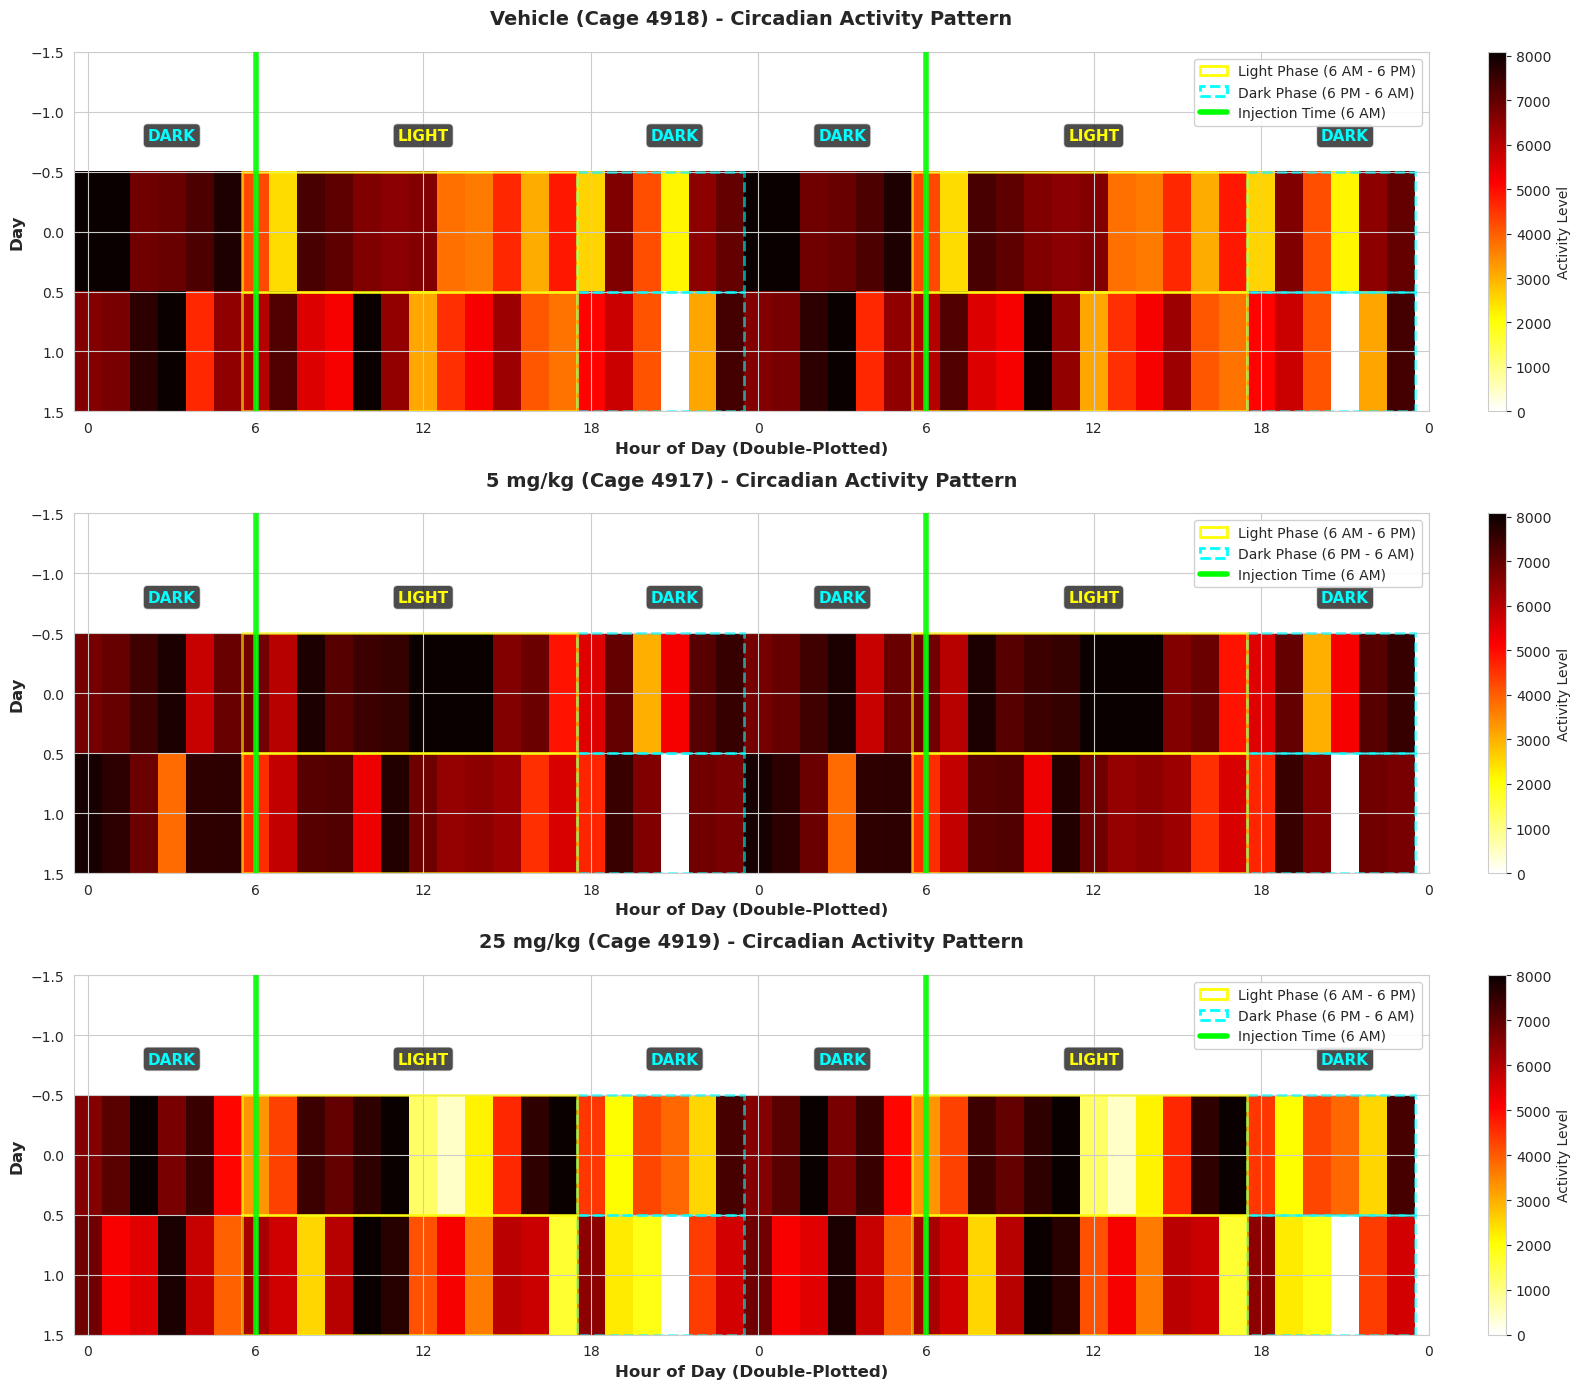


Creating high-contrast version...
✓ Saved: actograms_high_contrast.png


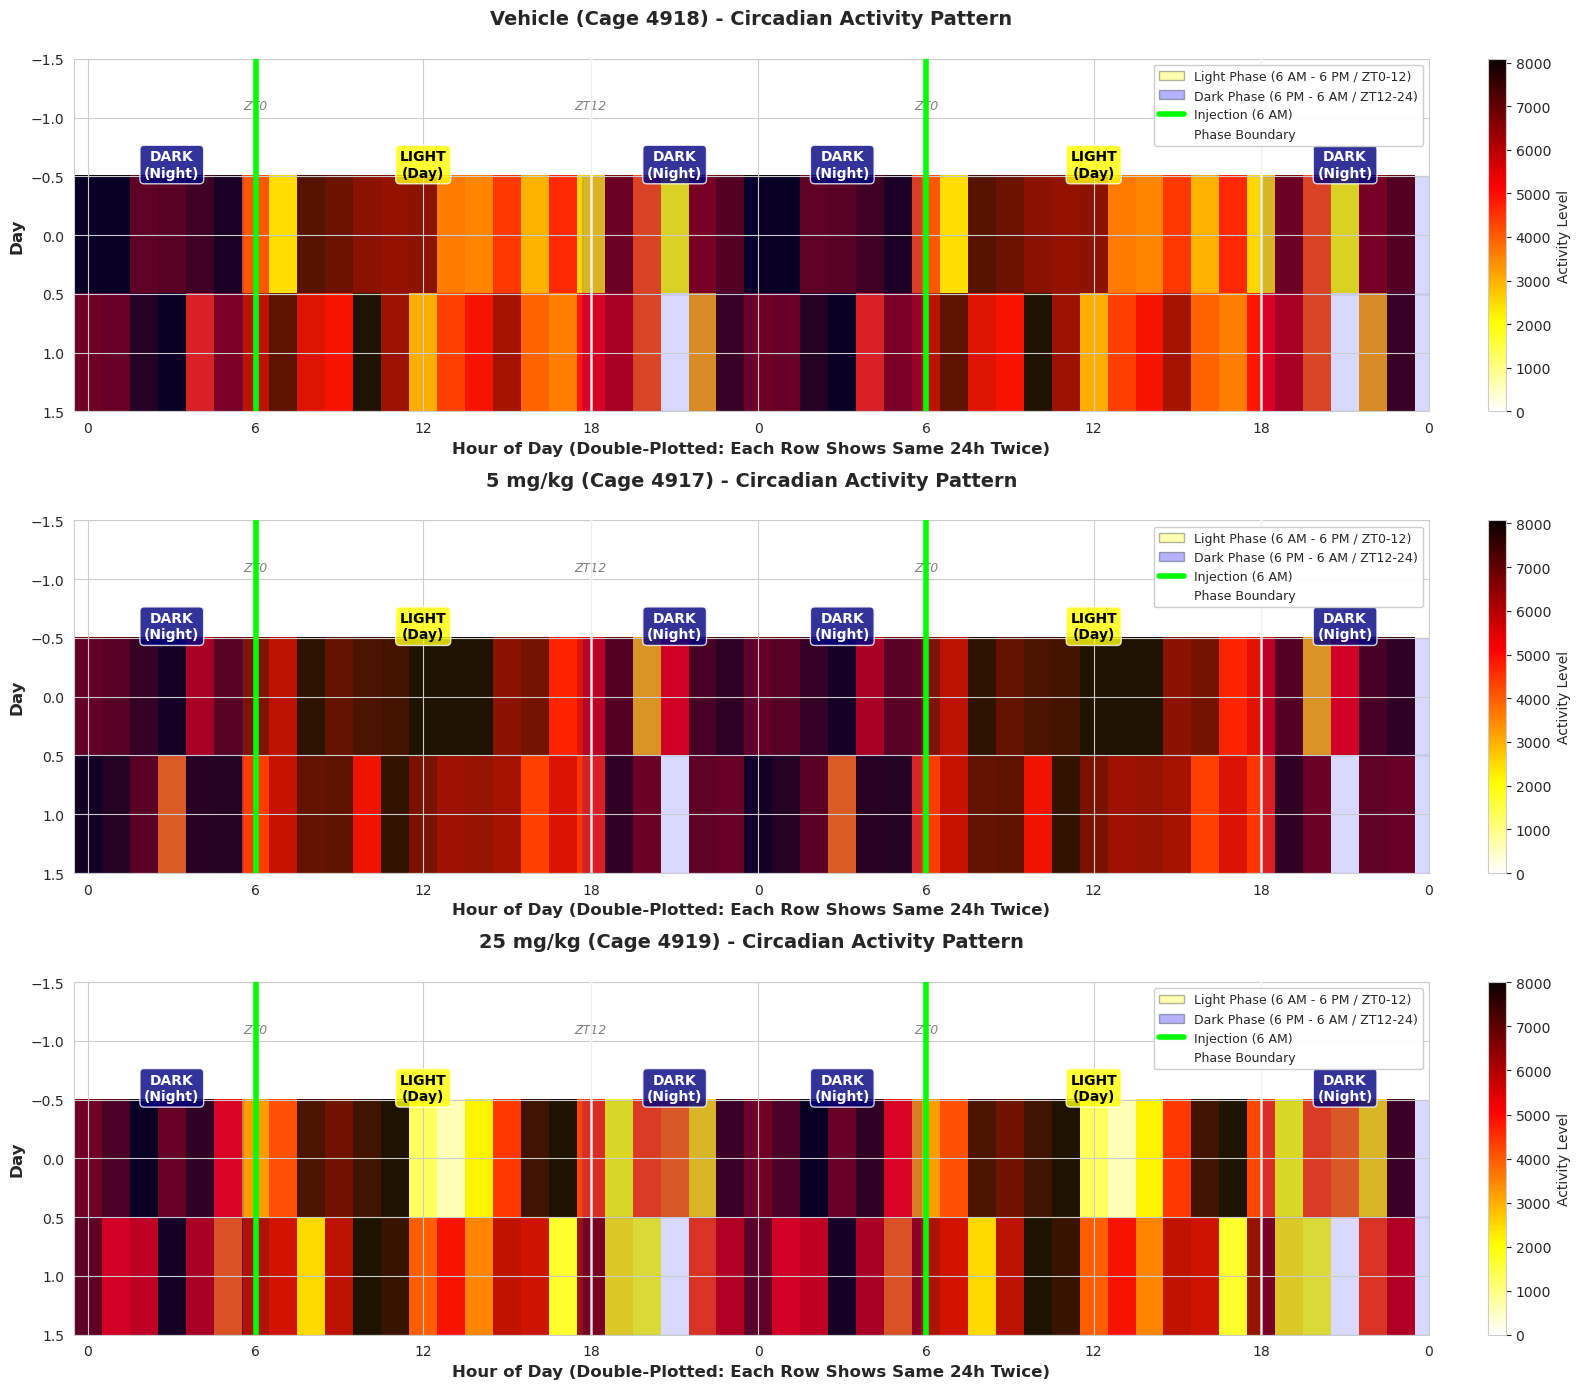


COMPLETE!

Generated 2 improved actogram visualizations:
  1. actograms_improved.png - Outlined phase boxes
  2. actograms_high_contrast.png - Background shading + ZT labels

Key improvements:
  - Yellow boxes/shading for light phase (6 AM - 6 PM)
  - Blue boxes/shading for dark phase (6 PM - 6 AM)
  - Lime green line for injection time
  - White vertical lines at phase boundaries
  - Zeitgeber Time (ZT) labels added


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import duckdb
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuration
TREATMENT_MAP = {
    4917: '5 mg/kg', 4918: 'Vehicle', 4919: '25 mg/kg',
    4920: '25 mg/kg', 4921: '5 mg/kg', 4922: 'Vehicle',
    4923: 'Vehicle', 4924: '25 mg/kg', 4925: '5 mg/kg'
}

INJECTION_DATETIME = datetime(2025, 1, 14, 6, 0, 0)

print("="*80)
print("IMPROVED DOUBLE-PLOTTED ACTOGRAMS")
print("="*80)
print("\nEnhancements:")
print("  - Clearer light/dark phase boundaries")
print("  - Better visual contrast")
print("  - Explicit phase labels")
print("="*80)

# Initialize DuckDB
con = duckdb.connect()
con.execute("SET s3_region='us-east-1';")
con.execute("SET s3_url_style='path';")

def generate_paths(cages, dates, filename):
    paths = []
    for cage in cages:
        for date in dates:
            path = f"s3://jax-envision-public-data/study_1001/2025v3.3/tabular/cage_id={cage}/date={date}/{filename}"
            paths.append(f"'{path}'")
    return ', '.join(paths)

dates = [(INJECTION_DATETIME + timedelta(days=d)).strftime('%Y-%m-%d') 
         for d in range(0, 2)]
cages = list(TREATMENT_MAP.keys())

print("\nLoading activity data...")
activity_paths = generate_paths(cages, dates, 'animal_activity_db.parquet')
query = f"""
SELECT 
    cage_id,
    time,
    name,
    value
FROM read_parquet([{activity_paths}])
WHERE resolution = 1
    AND name = 'animal_bouts.active'
ORDER BY cage_id, time
"""
df = con.execute(query).df()
df['time'] = pd.to_datetime(df['time'])
df['treatment'] = df['cage_id'].map(TREATMENT_MAP)

print(f"✓ Loaded {len(df):,} activity records")

# Select one representative cage per treatment
representative_cages = {
    'Vehicle': 4918,
    '5 mg/kg': 4917,
    '25 mg/kg': 4919
}

print("\nCreating improved actograms...")

fig, axes = plt.subplots(3, 1, figsize=(16, 14))

for idx, (treatment, cage_id) in enumerate(representative_cages.items()):
    ax = axes[idx]
    
    cage_data = df[df['cage_id'] == cage_id].copy()
    cage_data = cage_data.sort_values('time')
    
    # Create bins by day and hour
    cage_data['day'] = (cage_data['time'] - cage_data['time'].min()).dt.days
    cage_data['hour_float'] = (cage_data['time'].dt.hour + 
                                cage_data['time'].dt.minute/60 + 
                                cage_data['time'].dt.second/3600)
    
    # Create matrix for actogram
    days = cage_data['day'].max() + 1
    hours_matrix = np.zeros((days, 48))  # Double-plotted: 48 hours
    
    for _, row in cage_data.iterrows():
        day = int(row['day'])
        hour = int(row['hour_float'])
        
        if day < days:
            # First 24 hours
            if hour < 48:
                hours_matrix[day, hour] += row['value']
            # Second 24 hours (duplicate)
            if hour + 24 < 48:
                hours_matrix[day, hour + 24] += row['value']
    
    # Plot with better colormap
    im = ax.imshow(hours_matrix, aspect='auto', cmap='hot_r', 
                   interpolation='nearest', origin='upper',
                   vmin=0, vmax=np.percentile(hours_matrix, 95))
    
    # Add DARK PHASE shading - MORE PROMINENT
    # Dark phase is 6 PM - 6 AM (hours 18-24 and 0-6, which is 18-30 in doubled plot)
    for day in range(days):
        # First dark phase (18-24, which is 18-30 in doubled)
        rect1 = mpatches.Rectangle((18-0.5, day-0.5), 6, 1, 
                                   linewidth=2, edgecolor='cyan', 
                                   facecolor='none', linestyle='--',
                                   alpha=0.6, zorder=10)
        ax.add_patch(rect1)
        
        # Light phase boundary (6-18)
        rect2 = mpatches.Rectangle((6-0.5, day-0.5), 12, 1, 
                                   linewidth=2, edgecolor='yellow', 
                                   facecolor='none', linestyle='-',
                                   alpha=0.6, zorder=10)
        ax.add_patch(rect2)
        
        # Second occurrence - dark phase (42-48, which is 18-24 repeated)
        rect3 = mpatches.Rectangle((42-0.5, day-0.5), 6, 1, 
                                   linewidth=2, edgecolor='cyan', 
                                   facecolor='none', linestyle='--',
                                   alpha=0.6, zorder=10)
        ax.add_patch(rect3)
        
        # Second occurrence - light phase (30-42)
        rect4 = mpatches.Rectangle((30-0.5, day-0.5), 12, 1, 
                                   linewidth=2, edgecolor='yellow', 
                                   facecolor='none', linestyle='-',
                                   alpha=0.6, zorder=10)
        ax.add_patch(rect4)
    
    # Mark injection time with more prominent line
    ax.axvline(x=6, color='lime', linewidth=4, linestyle='-', 
              label='Injection (6 AM)', alpha=0.9, zorder=15)
    ax.axvline(x=30, color='lime', linewidth=4, linestyle='-', 
              alpha=0.9, zorder=15)
    
    # Add phase labels at top
    ax.text(3, -0.8, 'DARK', ha='center', va='center', 
           fontsize=11, fontweight='bold', color='cyan',
           bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    ax.text(12, -0.8, 'LIGHT', ha='center', va='center', 
           fontsize=11, fontweight='bold', color='yellow',
           bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    ax.text(21, -0.8, 'DARK', ha='center', va='center', 
           fontsize=11, fontweight='bold', color='cyan',
           bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    
    ax.text(27, -0.8, 'DARK', ha='center', va='center', 
           fontsize=11, fontweight='bold', color='cyan',
           bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    ax.text(36, -0.8, 'LIGHT', ha='center', va='center', 
           fontsize=11, fontweight='bold', color='yellow',
           bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    ax.text(45, -0.8, 'DARK', ha='center', va='center', 
           fontsize=11, fontweight='bold', color='cyan',
           bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    
    ax.set_ylabel('Day', fontsize=12, fontweight='bold')
    ax.set_xlabel('Hour of Day (Double-Plotted)', fontsize=12, fontweight='bold')
    ax.set_title(f'{treatment} (Cage {cage_id}) - Circadian Activity Pattern', 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(range(0, 49, 6))
    ax.set_xticklabels([f'{h%24}' for h in range(0, 49, 6)])
    ax.set_ylim(days-0.5, -1.5)  # Extra space for labels
    
    # Legend
    legend_elements = [
        mpatches.Patch(facecolor='none', edgecolor='yellow', linewidth=2, 
                      label='Light Phase (6 AM - 6 PM)'),
        mpatches.Patch(facecolor='none', edgecolor='cyan', linewidth=2, linestyle='--',
                      label='Dark Phase (6 PM - 6 AM)'),
        plt.Line2D([0], [0], color='lime', linewidth=4, label='Injection Time (6 AM)')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, 
             framealpha=0.9)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, label='Activity Level', fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig('actograms_improved.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✓ Saved: actograms_improved.png")
plt.show()

# Also create a version with even more contrast
print("\nCreating high-contrast version...")

fig, axes = plt.subplots(3, 1, figsize=(16, 14))

for idx, (treatment, cage_id) in enumerate(representative_cages.items()):
    ax = axes[idx]
    
    cage_data = df[df['cage_id'] == cage_id].copy()
    cage_data = cage_data.sort_values('time')
    
    # Create bins by day and hour
    cage_data['day'] = (cage_data['time'] - cage_data['time'].min()).dt.days
    cage_data['hour_float'] = (cage_data['time'].dt.hour + 
                                cage_data['time'].dt.minute/60 + 
                                cage_data['time'].dt.second/3600)
    
    # Create matrix for actogram
    days = cage_data['day'].max() + 1
    hours_matrix = np.zeros((days, 48))
    
    for _, row in cage_data.iterrows():
        day = int(row['day'])
        hour = int(row['hour_float'])
        
        if day < days:
            if hour < 48:
                hours_matrix[day, hour] += row['value']
            if hour + 24 < 48:
                hours_matrix[day, hour + 24] += row['value']
    
    # Plot the activity data
    im = ax.imshow(hours_matrix, aspect='auto', cmap='hot_r', 
                   interpolation='nearest', origin='upper',
                   vmin=0, vmax=np.percentile(hours_matrix, 95))
    
    # Add SOLID background shading for dark phases
    for day in range(days):
        # Dark phase background (hours 0-6 and 18-24 in first plot)
        ax.axhspan(day-0.5, day+0.5, xmin=0/48, xmax=6/48, 
                  alpha=0.15, color='blue', zorder=0)
        ax.axhspan(day-0.5, day+0.5, xmin=18/48, xmax=24/48, 
                  alpha=0.15, color='blue', zorder=0)
        
        # Dark phase background (repeated in second plot)
        ax.axhspan(day-0.5, day+0.5, xmin=24/48, xmax=30/48, 
                  alpha=0.15, color='blue', zorder=0)
        ax.axhspan(day-0.5, day+0.5, xmin=42/48, xmax=48/48, 
                  alpha=0.15, color='blue', zorder=0)
        
        # Light phase background
        ax.axhspan(day-0.5, day+0.5, xmin=6/48, xmax=18/48, 
                  alpha=0.08, color='yellow', zorder=0)
        ax.axhspan(day-0.5, day+0.5, xmin=30/48, xmax=42/48, 
                  alpha=0.08, color='yellow', zorder=0)
    
    # Add vertical lines at phase boundaries
    for hour in [6, 18, 30, 42]:
        ax.axvline(x=hour, color='white', linewidth=2, linestyle='-', 
                  alpha=0.7, zorder=5)
    
    # Mark injection time
    ax.axvline(x=6, color='lime', linewidth=4, linestyle='-', 
              label='Injection (6 AM)', alpha=1, zorder=15)
    ax.axvline(x=30, color='lime', linewidth=4, linestyle='-', 
              alpha=1, zorder=15)
    
    # Add phase labels at top with better positioning
    label_y = -0.6
    ax.text(3, label_y, 'DARK\n(Night)', ha='center', va='center', 
           fontsize=10, fontweight='bold', color='white',
           bbox=dict(boxstyle='round', facecolor='navy', alpha=0.8))
    ax.text(12, label_y, 'LIGHT\n(Day)', ha='center', va='center', 
           fontsize=10, fontweight='bold', color='black',
           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
    ax.text(21, label_y, 'DARK\n(Night)', ha='center', va='center', 
           fontsize=10, fontweight='bold', color='white',
           bbox=dict(boxstyle='round', facecolor='navy', alpha=0.8))
    
    ax.text(27, label_y, 'DARK\n(Night)', ha='center', va='center', 
           fontsize=10, fontweight='bold', color='white',
           bbox=dict(boxstyle='round', facecolor='navy', alpha=0.8))
    ax.text(36, label_y, 'LIGHT\n(Day)', ha='center', va='center', 
           fontsize=10, fontweight='bold', color='black',
           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
    ax.text(45, label_y, 'DARK\n(Night)', ha='center', va='center', 
           fontsize=10, fontweight='bold', color='white',
           bbox=dict(boxstyle='round', facecolor='navy', alpha=0.8))
    
    # Add ZT labels
    zt_y = -1.1
    ax.text(6, zt_y, 'ZT0', ha='center', va='center', 
           fontsize=9, style='italic', color='gray')
    ax.text(18, zt_y, 'ZT12', ha='center', va='center', 
           fontsize=9, style='italic', color='gray')
    ax.text(30, zt_y, 'ZT0', ha='center', va='center', 
           fontsize=9, style='italic', color='gray')
    ax.text(42, zt_y, 'ZT12', ha='center', va='center', 
           fontsize=9, style='italic', color='gray')
    
    ax.set_ylabel('Day', fontsize=12, fontweight='bold')
    ax.set_xlabel('Hour of Day (Double-Plotted: Each Row Shows Same 24h Twice)', 
                 fontsize=12, fontweight='bold')
    ax.set_title(f'{treatment} (Cage {cage_id}) - Circadian Activity Pattern', 
                fontsize=14, fontweight='bold', pad=25)
    ax.set_xticks(range(0, 49, 6))
    ax.set_xticklabels([f'{h%24}' for h in range(0, 49, 6)])
    ax.set_ylim(days-0.5, -1.5)
    
    # Legend
    legend_elements = [
        mpatches.Patch(facecolor='yellow', edgecolor='black', alpha=0.3,
                      label='Light Phase (6 AM - 6 PM / ZT0-12)'),
        mpatches.Patch(facecolor='blue', edgecolor='black', alpha=0.3,
                      label='Dark Phase (6 PM - 6 AM / ZT12-24)'),
        plt.Line2D([0], [0], color='lime', linewidth=4, label='Injection (6 AM)'),
        plt.Line2D([0], [0], color='white', linewidth=2, label='Phase Boundary')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=9, 
             framealpha=0.95)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, label='Activity Level', fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig('actograms_high_contrast.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✓ Saved: actograms_high_contrast.png")
plt.show()

con.close()

print("\n" + "="*80)
print("COMPLETE!")
print("="*80)
print("\nGenerated 2 improved actogram visualizations:")
print("  1. actograms_improved.png - Outlined phase boxes")
print("  2. actograms_high_contrast.png - Background shading + ZT labels")
print("\nKey improvements:")
print("  - Yellow boxes/shading for light phase (6 AM - 6 PM)")
print("  - Blue boxes/shading for dark phase (6 PM - 6 AM)")
print("  - Lime green line for injection time")
print("  - White vertical lines at phase boundaries")
print("  - Zeitgeber Time (ZT) labels added")
print("="*80)

ACTOGRAMS - SHOWING ACTUAL POST-INJECTION DAYS

Showing Day 0 (injection day) and Day 1 (next day)
This reveals how morphine effects change over time!

Loading activity data...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ Loaded 76,065 activity records

Creating actograms showing Day 0 and Day 1...
✓ Saved: actograms_actual_days.png


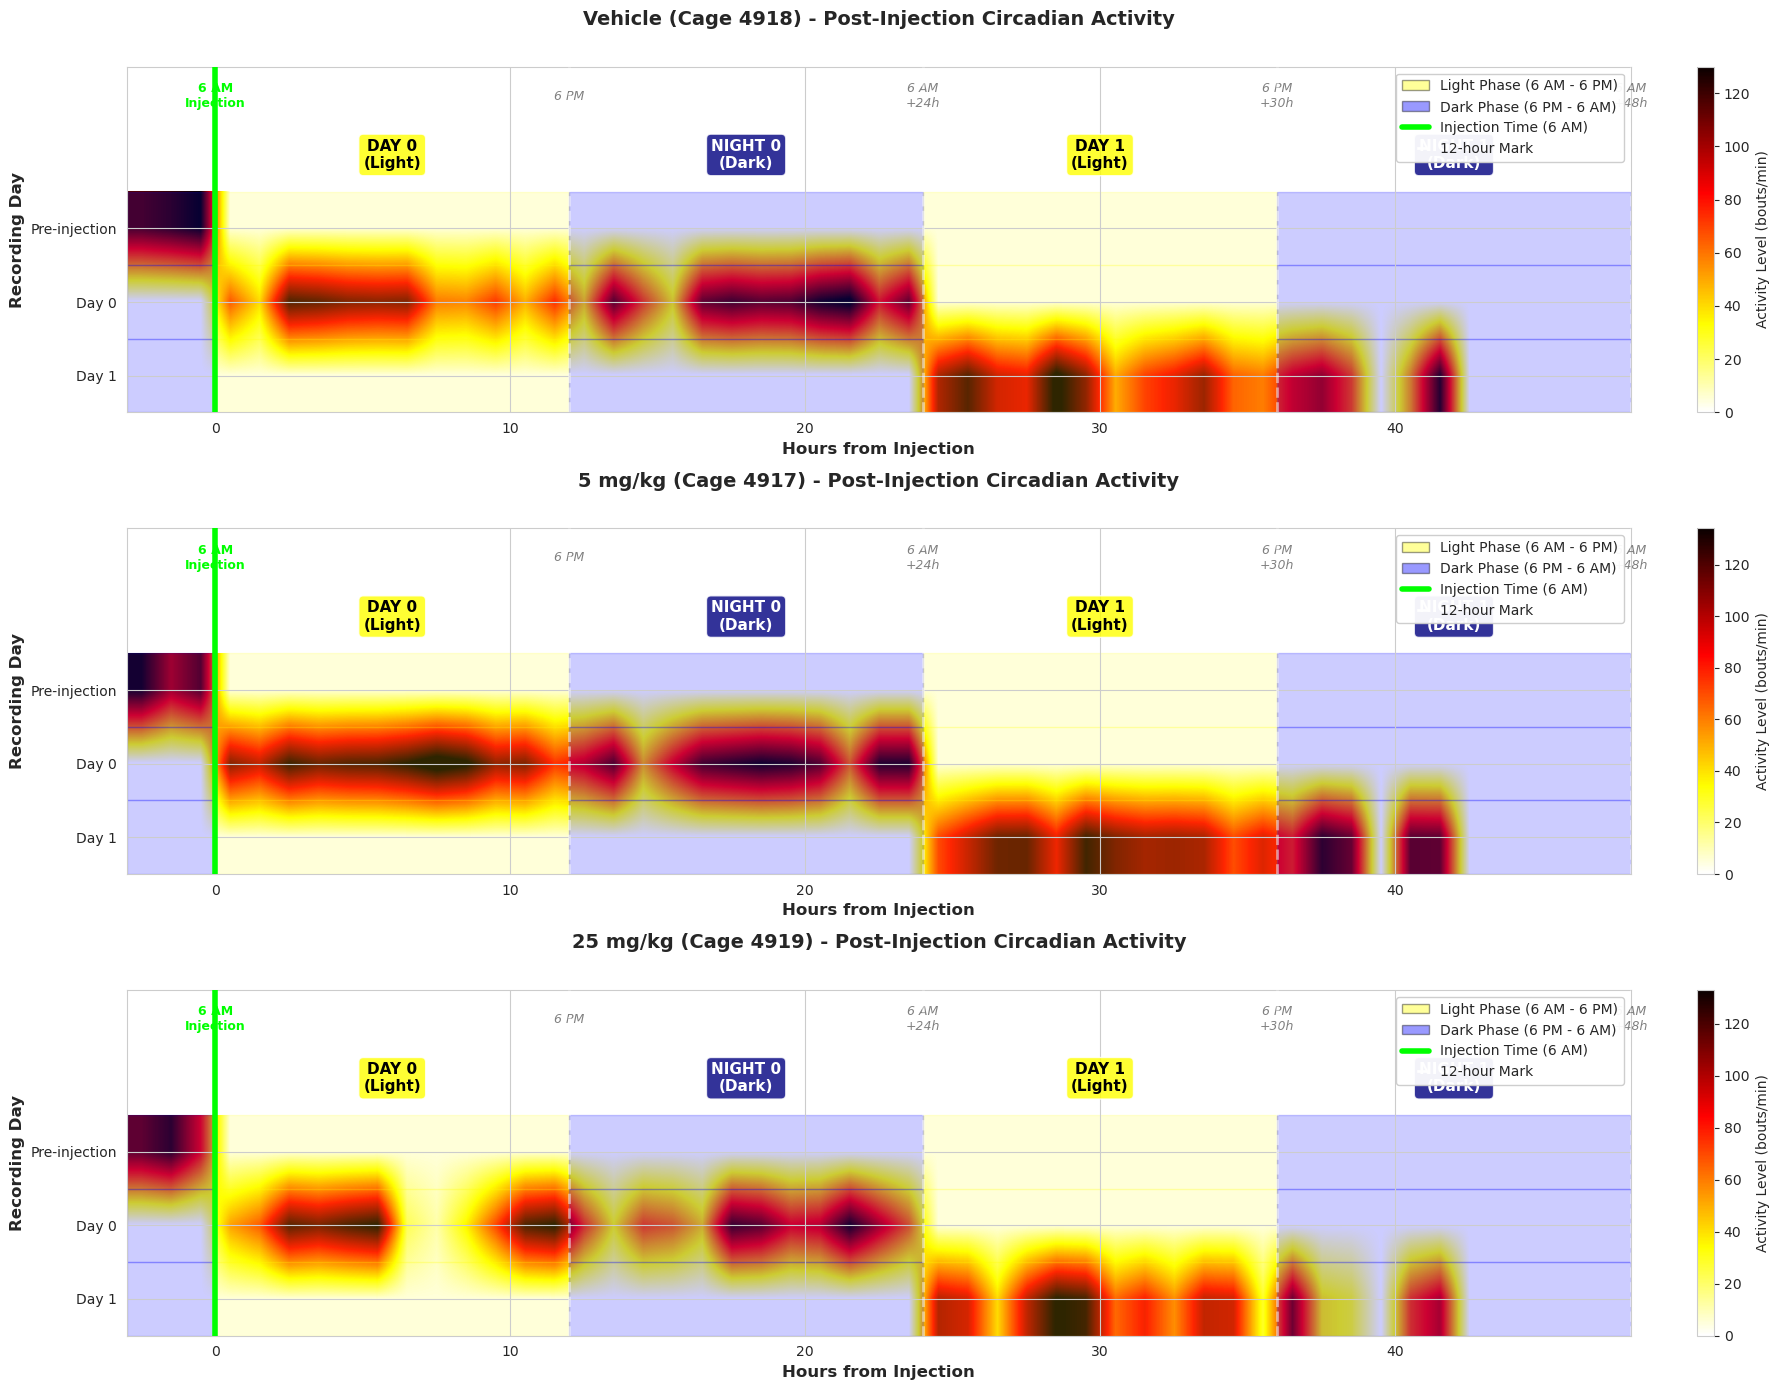


Creating detailed hour-by-hour version...
✓ Saved: actograms_hourly_timeseries.png


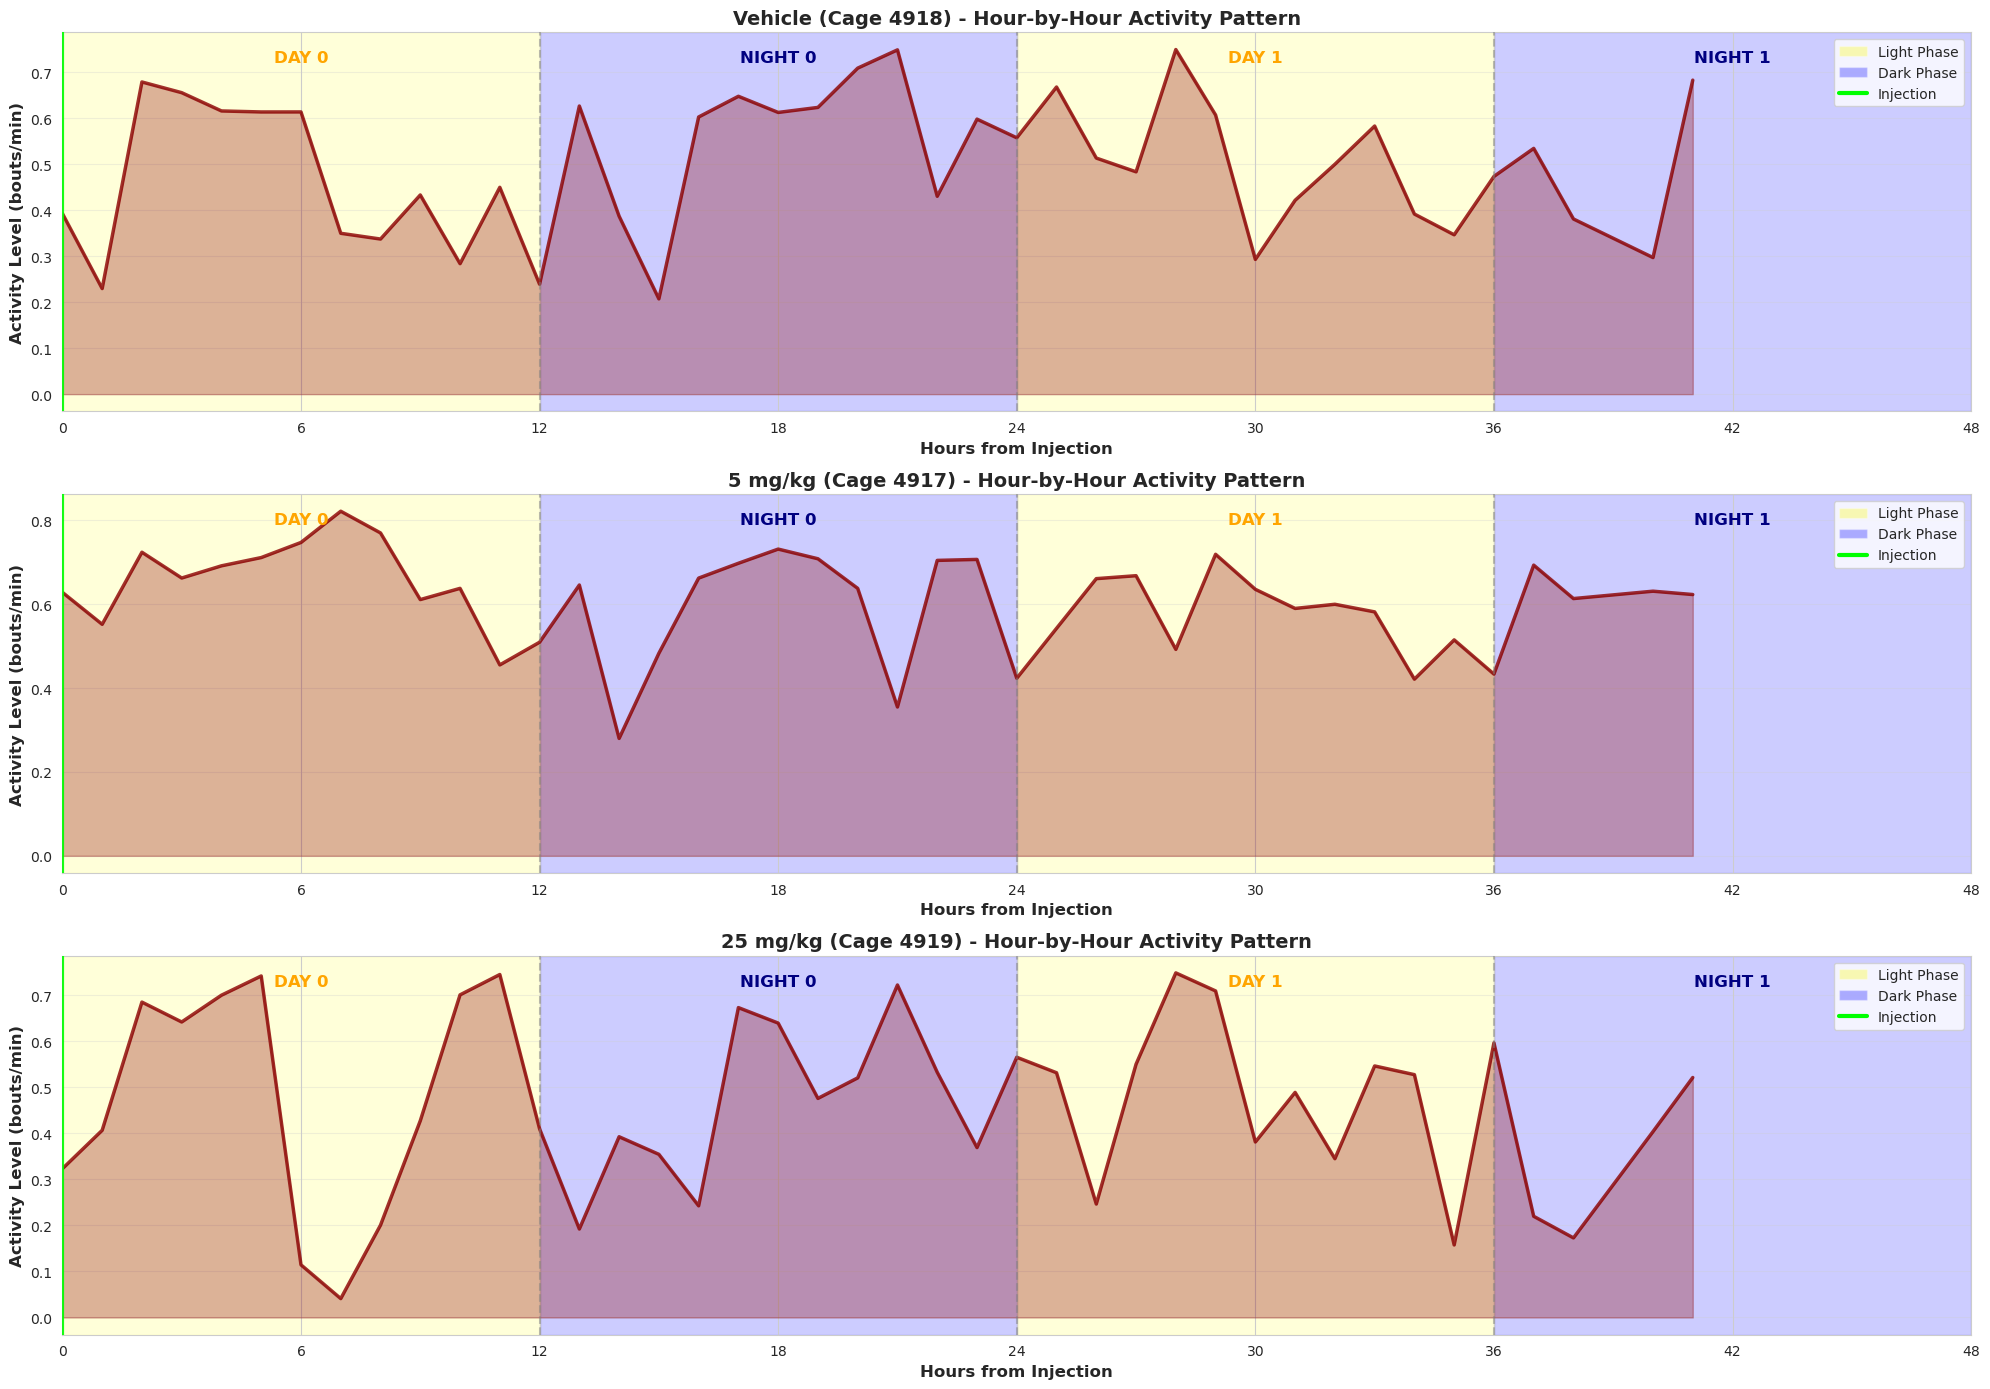


COMPLETE!

Generated 2 visualizations showing ACTUAL post-injection time:
  1. actograms_actual_days.png - Heatmap showing Day 0 and Day 1
  2. actograms_hourly_timeseries.png - Line graph showing 48-hour pattern

Key insights you can now see:
  - How quickly morphine effects kick in after injection
  - Whether effects persist into Day 1 or recover
  - Exact timing of circadian disruption relative to injection
  - Comparison of Day 0 vs Day 1 patterns


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import duckdb
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuration
TREATMENT_MAP = {
    4917: '5 mg/kg', 4918: 'Vehicle', 4919: '25 mg/kg',
    4920: '25 mg/kg', 4921: '5 mg/kg', 4922: 'Vehicle',
    4923: 'Vehicle', 4924: '25 mg/kg', 4925: '5 mg/kg'
}

INJECTION_DATETIME = datetime(2025, 1, 14, 6, 0, 0)

print("="*80)
print("ACTOGRAMS - SHOWING ACTUAL POST-INJECTION DAYS")
print("="*80)
print("\nShowing Day 0 (injection day) and Day 1 (next day)")
print("This reveals how morphine effects change over time!")
print("="*80)

# Initialize DuckDB
con = duckdb.connect()
con.execute("SET s3_region='us-east-1';")
con.execute("SET s3_url_style='path';")

def generate_paths(cages, dates, filename):
    paths = []
    for cage in cages:
        for date in dates:
            path = f"s3://jax-envision-public-data/study_1001/2025v3.3/tabular/cage_id={cage}/date={date}/{filename}"
            paths.append(f"'{path}'")
    return ', '.join(paths)

dates = [(INJECTION_DATETIME + timedelta(days=d)).strftime('%Y-%m-%d') 
         for d in range(0, 2)]
cages = list(TREATMENT_MAP.keys())

print("\nLoading activity data...")
activity_paths = generate_paths(cages, dates, 'animal_activity_db.parquet')
query = f"""
SELECT 
    cage_id,
    time,
    name,
    value
FROM read_parquet([{activity_paths}])
WHERE resolution = 60  -- Use 1-minute resolution for smoother visualization
    AND name = 'animal_bouts.active'
ORDER BY cage_id, time
"""
df = con.execute(query).df()
df['time'] = pd.to_datetime(df['time'])
df['treatment'] = df['cage_id'].map(TREATMENT_MAP)
df['minutes_from_injection'] = (df['time'] - INJECTION_DATETIME).dt.total_seconds() / 60
df['hours_from_injection'] = df['minutes_from_injection'] / 60

print(f"✓ Loaded {len(df):,} activity records")

# Select one representative cage per treatment
representative_cages = {
    'Vehicle': 4918,
    '5 mg/kg': 4917,
    '25 mg/kg': 4919
}

print("\nCreating actograms showing Day 0 and Day 1...")

fig, axes = plt.subplots(3, 1, figsize=(18, 14))

for idx, (treatment, cage_id) in enumerate(representative_cages.items()):
    ax = axes[idx]
    
    cage_data = df[df['cage_id'] == cage_id].copy()
    cage_data = cage_data[(cage_data['hours_from_injection'] >= -3) & 
                          (cage_data['hours_from_injection'] < 48)]  # Show 3h before injection through 48h after
    
    if len(cage_data) == 0:
        print(f"  Warning: No data for cage {cage_id}")
        continue
    
    # Create hour bins (0-51 hours, where 0 = injection time)
    cage_data['hour_bin'] = ((cage_data['hours_from_injection'] + 3) // 1).astype(int)  # Shift so hour 0 = 3h before injection
    
    # Create day bins
    cage_data['day_bin'] = (cage_data['hours_from_injection'] // 24).astype(int)
    cage_data.loc[cage_data['hours_from_injection'] < 0, 'day_bin'] = -1  # Pre-injection
    
    # Create matrix: rows = days, columns = hours
    hour_bins = np.arange(0, 51)  # 51 hours total (-3 to 48)
    day_bins = sorted(cage_data['day_bin'].unique())
    
    activity_matrix = np.zeros((len(day_bins), len(hour_bins)))
    
    for day_idx, day in enumerate(day_bins):
        day_data = cage_data[cage_data['day_bin'] == day]
        for _, row in day_data.iterrows():
            hour_idx = row['hour_bin']
            if 0 <= hour_idx < len(hour_bins):
                activity_matrix[day_idx, hour_idx] += row['value']
    
    # Plot
    im = ax.imshow(activity_matrix, aspect='auto', cmap='hot_r', 
                   interpolation='bilinear', origin='upper',
                   vmin=0, vmax=np.percentile(activity_matrix[activity_matrix > 0], 95),
                   extent=[-3, 48, len(day_bins)-0.5, -0.5])
    
    # Add phase shading - adjusted for actual time axis
    for day_idx in range(len(day_bins)):
        # Light phases: 6 AM - 6 PM (injection at 6 AM = hour 0)
        # Day 0: 0-12h (6 AM - 6 PM)
        # Night 0: 12-24h (6 PM - 6 AM next day)
        # Day 1: 24-36h (6 AM - 6 PM next day)
        # Night 1: 36-48h (6 PM - 6 AM next day)
        
        # Pre-injection dark phase
        ax.axhspan(day_idx-0.5, day_idx+0.5, xmin=(-3+3)/51, xmax=(0+3)/51, 
                  alpha=0.2, color='blue', zorder=0, label='_nolegend_')
        
        # Day 0 light phase (0-12h)
        ax.axhspan(day_idx-0.5, day_idx+0.5, xmin=(0+3)/51, xmax=(12+3)/51, 
                  alpha=0.15, color='yellow', zorder=0, label='_nolegend_')
        
        # Night 0 dark phase (12-24h)
        ax.axhspan(day_idx-0.5, day_idx+0.5, xmin=(12+3)/51, xmax=(24+3)/51, 
                  alpha=0.2, color='blue', zorder=0, label='_nolegend_')
        
        # Day 1 light phase (24-36h)
        ax.axhspan(day_idx-0.5, day_idx+0.5, xmin=(24+3)/51, xmax=(36+3)/51, 
                  alpha=0.15, color='yellow', zorder=0, label='_nolegend_')
        
        # Night 1 dark phase (36-48h)
        ax.axhspan(day_idx-0.5, day_idx+0.5, xmin=(36+3)/51, xmax=(48+3)/51, 
                  alpha=0.2, color='blue', zorder=0, label='_nolegend_')
    
    # Add vertical lines at phase boundaries
    for hour in [0, 12, 24, 36, 48]:
        if hour == 0:
            # Injection time - make it prominent
            ax.axvline(x=hour, color='lime', linewidth=4, linestyle='-', 
                      alpha=1, zorder=10)
        else:
            ax.axvline(x=hour, color='white', linewidth=2, linestyle='--', 
                      alpha=0.5, zorder=5)
    
    # Add phase labels at top
    label_y = -1.0
    ax.text(6, label_y, 'DAY 0\n(Light)', ha='center', va='center', 
           fontsize=11, fontweight='bold', color='black',
           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
    ax.text(18, label_y, 'NIGHT 0\n(Dark)', ha='center', va='center', 
           fontsize=11, fontweight='bold', color='white',
           bbox=dict(boxstyle='round', facecolor='navy', alpha=0.8))
    ax.text(30, label_y, 'DAY 1\n(Light)', ha='center', va='center', 
           fontsize=11, fontweight='bold', color='black',
           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
    ax.text(42, label_y, 'NIGHT 1\n(Dark)', ha='center', va='center', 
           fontsize=11, fontweight='bold', color='white',
           bbox=dict(boxstyle='round', facecolor='navy', alpha=0.8))
    
    # Add time markers
    time_y = -1.8
    ax.text(0, time_y, '6 AM\nInjection', ha='center', va='center', 
           fontsize=9, color='lime', fontweight='bold')
    ax.text(12, time_y, '6 PM', ha='center', va='center', 
           fontsize=9, color='gray', style='italic')
    ax.text(24, time_y, '6 AM\n+24h', ha='center', va='center', 
           fontsize=9, color='gray', style='italic')
    ax.text(36, time_y, '6 PM\n+30h', ha='center', va='center', 
           fontsize=9, color='gray', style='italic')
    ax.text(48, time_y, '6 AM\n+48h', ha='center', va='center', 
           fontsize=9, color='gray', style='italic')
    
    # Format axes
    ax.set_ylabel('Recording Day', fontsize=12, fontweight='bold')
    ax.set_xlabel('Hours from Injection', fontsize=12, fontweight='bold')
    ax.set_title(f'{treatment} (Cage {cage_id}) - Post-Injection Circadian Activity', 
                fontsize=14, fontweight='bold', pad=30)
    ax.set_xlim(-3, 48)
    ax.set_ylim(len(day_bins)-0.5, -2.2)
    
    # Y-axis labels
    y_labels = []
    for day in day_bins:
        if day == -1:
            y_labels.append('Pre-injection')
        else:
            y_labels.append(f'Day {day}')
    ax.set_yticks(range(len(day_bins)))
    ax.set_yticklabels(y_labels)
    
    # Legend
    legend_elements = [
        mpatches.Patch(facecolor='yellow', edgecolor='black', alpha=0.4,
                      label='Light Phase (6 AM - 6 PM)'),
        mpatches.Patch(facecolor='blue', edgecolor='black', alpha=0.4,
                      label='Dark Phase (6 PM - 6 AM)'),
        plt.Line2D([0], [0], color='lime', linewidth=4, 
                  label='Injection Time (6 AM)'),
        plt.Line2D([0], [0], color='white', linewidth=2, linestyle='--',
                  label='12-hour Mark')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, 
             framealpha=0.95)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, label='Activity Level (bouts/min)', 
                       fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig('actograms_actual_days.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✓ Saved: actograms_actual_days.png")
plt.show()

# Create a version with even more detail - showing hour-by-hour
print("\nCreating detailed hour-by-hour version...")

fig, axes = plt.subplots(3, 1, figsize=(20, 14))

for idx, (treatment, cage_id) in enumerate(representative_cages.items()):
    ax = axes[idx]
    
    cage_data = df[df['cage_id'] == cage_id].copy()
    cage_data = cage_data[(cage_data['hours_from_injection'] >= 0) & 
                          (cage_data['hours_from_injection'] < 48)]
    
    if len(cage_data) == 0:
        continue
    
    # Group by hour and calculate mean activity
    hourly_data = []
    for hour in range(48):
        hour_data = cage_data[
            (cage_data['hours_from_injection'] >= hour) & 
            (cage_data['hours_from_injection'] < hour + 1)
        ]
        if len(hour_data) > 0:
            hourly_data.append({
                'hour': hour,
                'activity': hour_data['value'].mean(),
                'activity_std': hour_data['value'].std()
            })
    
    hourly_df = pd.DataFrame(hourly_data)
    
    # Plot as line graph
    hours = hourly_df['hour'].values
    activity = hourly_df['activity'].values
    
    ax.plot(hours, activity, linewidth=2.5, color='darkred', alpha=0.8)
    ax.fill_between(hours, 0, activity, alpha=0.3, color='darkred')
    
    # Add phase shading
    # Day 0 light (0-12)
    ax.axvspan(0, 12, alpha=0.15, color='yellow', zorder=0)
    # Night 0 dark (12-24)
    ax.axvspan(12, 24, alpha=0.2, color='blue', zorder=0)
    # Day 1 light (24-36)
    ax.axvspan(24, 36, alpha=0.15, color='yellow', zorder=0)
    # Night 1 dark (36-48)
    ax.axvspan(36, 48, alpha=0.2, color='blue', zorder=0)
    
    # Mark injection
    ax.axvline(x=0, color='lime', linewidth=3, linestyle='-', 
              label='Injection', alpha=0.9, zorder=10)
    
    # Phase boundary lines
    for hour in [12, 24, 36]:
        ax.axvline(x=hour, color='gray', linewidth=1.5, linestyle='--', 
                  alpha=0.5, zorder=5)
    
    # Add labels
    label_y = ax.get_ylim()[1] * 0.95
    ax.text(6, label_y, 'DAY 0', ha='center', va='top', 
           fontsize=12, fontweight='bold', color='orange')
    ax.text(18, label_y, 'NIGHT 0', ha='center', va='top', 
           fontsize=12, fontweight='bold', color='navy')
    ax.text(30, label_y, 'DAY 1', ha='center', va='top', 
           fontsize=12, fontweight='bold', color='orange')
    ax.text(42, label_y, 'NIGHT 1', ha='center', va='top', 
           fontsize=12, fontweight='bold', color='navy')
    
    ax.set_xlabel('Hours from Injection', fontsize=12, fontweight='bold')
    ax.set_ylabel('Activity Level (bouts/min)', fontsize=12, fontweight='bold')
    ax.set_title(f'{treatment} (Cage {cage_id}) - Hour-by-Hour Activity Pattern', 
                fontsize=14, fontweight='bold')
    ax.set_xlim(0, 48)
    ax.grid(alpha=0.3, axis='y')
    ax.set_xticks(range(0, 49, 6))
    
    # Add legend
    legend_elements = [
        mpatches.Patch(facecolor='yellow', alpha=0.3, label='Light Phase'),
        mpatches.Patch(facecolor='blue', alpha=0.3, label='Dark Phase'),
        plt.Line2D([0], [0], color='lime', linewidth=3, label='Injection')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('actograms_hourly_timeseries.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✓ Saved: actograms_hourly_timeseries.png")
plt.show()

con.close()

print("\n" + "="*80)
print("COMPLETE!")
print("="*80)
print("\nGenerated 2 visualizations showing ACTUAL post-injection time:")
print("  1. actograms_actual_days.png - Heatmap showing Day 0 and Day 1")
print("  2. actograms_hourly_timeseries.png - Line graph showing 48-hour pattern")
print("\nKey insights you can now see:")
print("  - How quickly morphine effects kick in after injection")
print("  - Whether effects persist into Day 1 or recover")
print("  - Exact timing of circadian disruption relative to injection")
print("  - Comparison of Day 0 vs Day 1 patterns")
print("="*80)

SINGLE-ROW TIMELINE ACTOGRAMS

Showing 48 hours post-injection as a continuous activity ribbon

Loading activity data...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ Loaded 76,065 activity records

Creating single-row timeline actograms...
✓ Saved: actograms_single_row.png


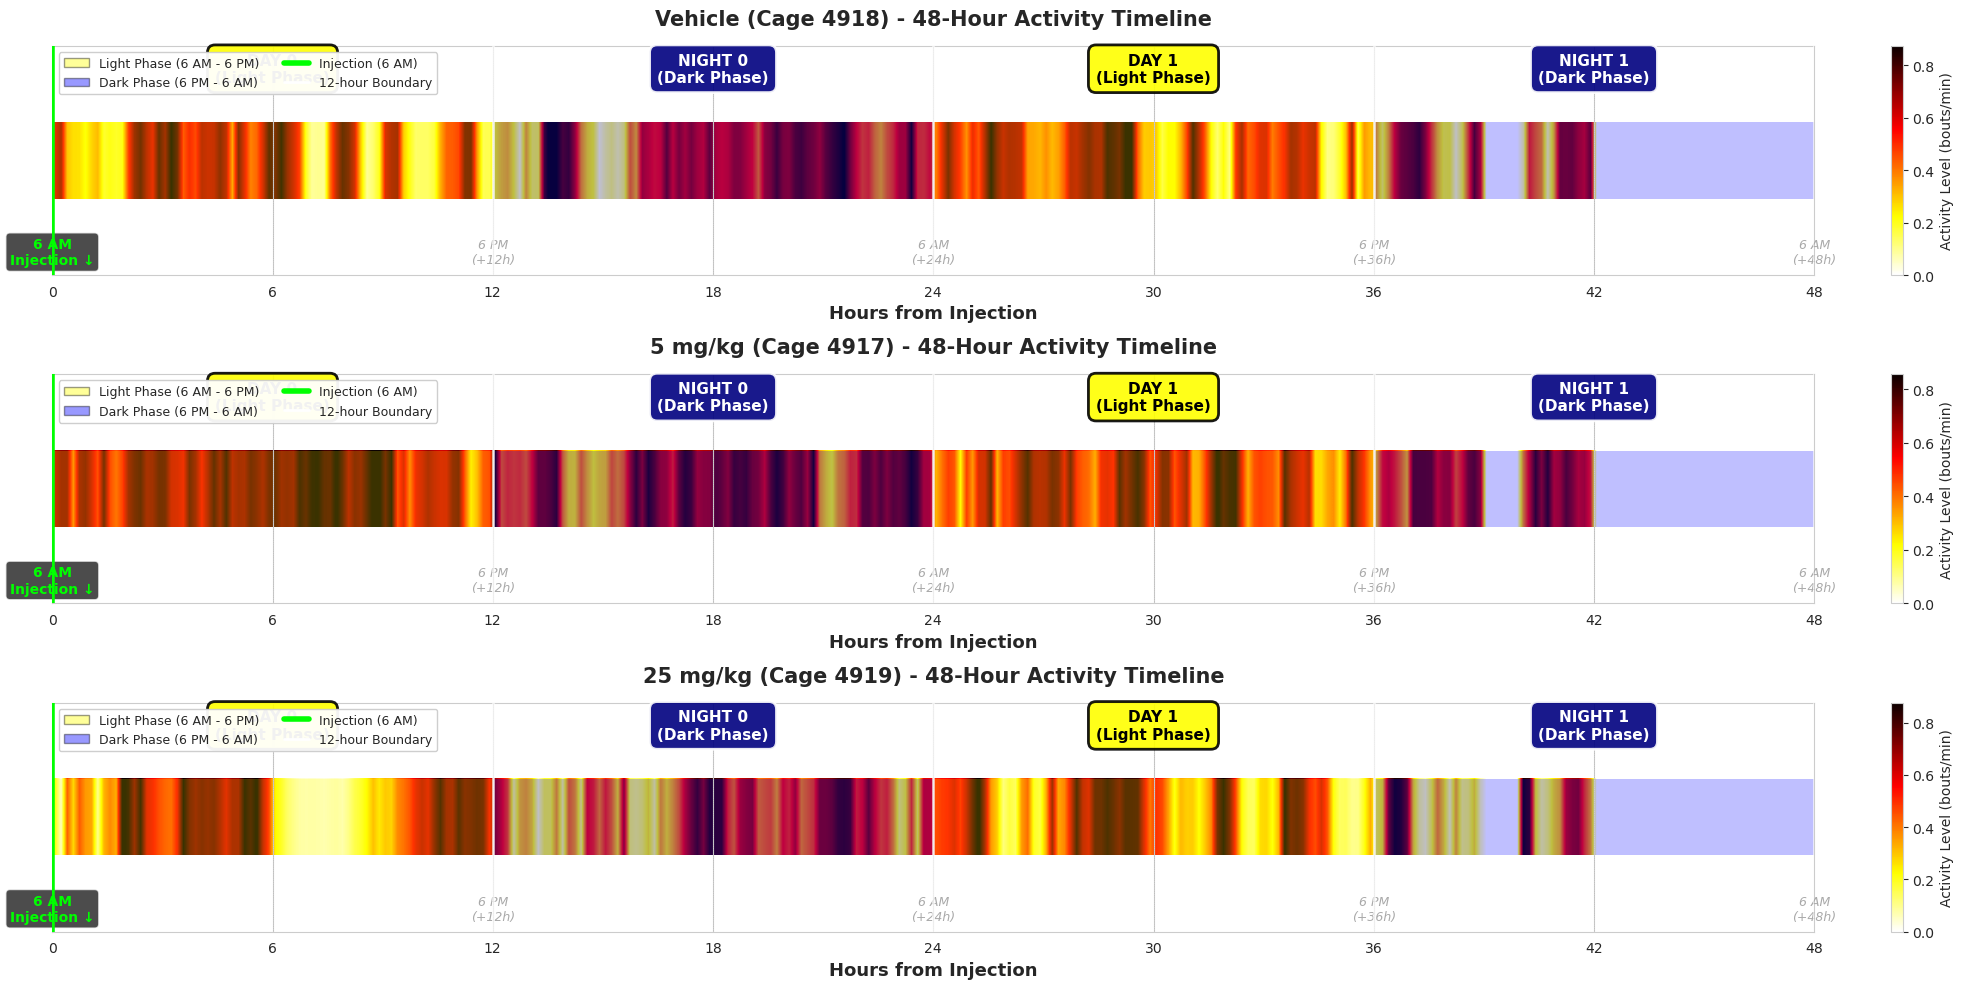


Creating companion line graph...
✓ Saved: actograms_line_graph.png


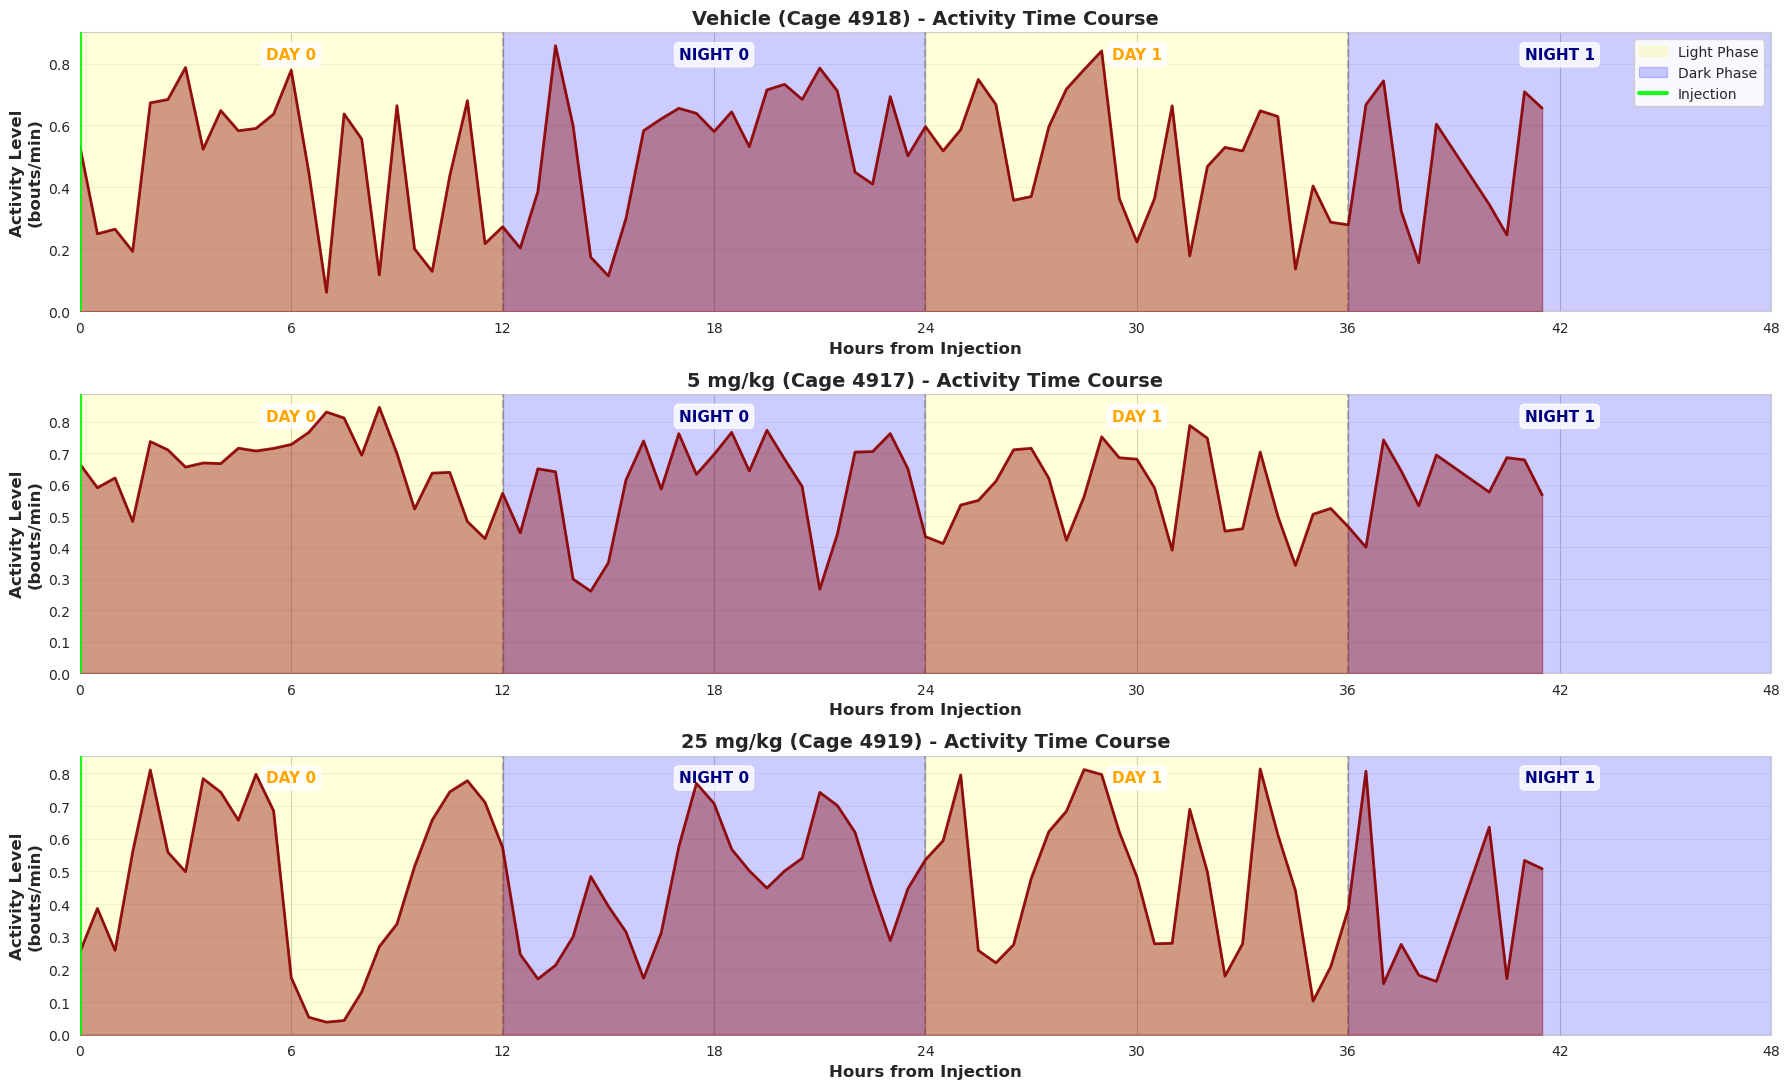


COMPLETE!

Generated 2 timeline visualizations:
  1. actograms_single_row.png - Heatmap ribbon (single row per treatment)
  2. actograms_line_graph.png - Line graph version

Key features:
  ✓ Single continuous 48-hour timeline
  ✓ No confusing y-axis
  ✓ Clear phase boundaries and labels
  ✓ Shows immediate post-injection effects through Day 1


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import duckdb
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuration
TREATMENT_MAP = {
    4917: '5 mg/kg', 4918: 'Vehicle', 4919: '25 mg/kg',
    4920: '25 mg/kg', 4921: '5 mg/kg', 4922: 'Vehicle',
    4923: 'Vehicle', 4924: '25 mg/kg', 4925: '5 mg/kg'
}

INJECTION_DATETIME = datetime(2025, 1, 14, 6, 0, 0)

print("="*80)
print("SINGLE-ROW TIMELINE ACTOGRAMS")
print("="*80)
print("\nShowing 48 hours post-injection as a continuous activity ribbon")
print("="*80)

# Initialize DuckDB
con = duckdb.connect()
con.execute("SET s3_region='us-east-1';")
con.execute("SET s3_url_style='path';")

def generate_paths(cages, dates, filename):
    paths = []
    for cage in cages:
        for date in dates:
            path = f"s3://jax-envision-public-data/study_1001/2025v3.3/tabular/cage_id={cage}/date={date}/{filename}"
            paths.append(f"'{path}'")
    return ', '.join(paths)

dates = [(INJECTION_DATETIME + timedelta(days=d)).strftime('%Y-%m-%d') 
         for d in range(0, 2)]
cages = list(TREATMENT_MAP.keys())

print("\nLoading activity data...")
activity_paths = generate_paths(cages, dates, 'animal_activity_db.parquet')
query = f"""
SELECT 
    cage_id,
    time,
    name,
    value
FROM read_parquet([{activity_paths}])
WHERE resolution = 60  -- Use 1-minute resolution
    AND name = 'animal_bouts.active'
ORDER BY cage_id, time
"""
df = con.execute(query).df()
df['time'] = pd.to_datetime(df['time'])
df['treatment'] = df['cage_id'].map(TREATMENT_MAP)
df['minutes_from_injection'] = (df['time'] - INJECTION_DATETIME).dt.total_seconds() / 60
df['hours_from_injection'] = df['minutes_from_injection'] / 60

print(f"✓ Loaded {len(df):,} activity records")

# Select one representative cage per treatment
representative_cages = {
    'Vehicle': 4918,
    '5 mg/kg': 4917,
    '25 mg/kg': 4919
}

print("\nCreating single-row timeline actograms...")

fig, axes = plt.subplots(3, 1, figsize=(20, 10))

for idx, (treatment, cage_id) in enumerate(representative_cages.items()):
    ax = axes[idx]
    
    cage_data = df[df['cage_id'] == cage_id].copy()
    cage_data = cage_data[(cage_data['hours_from_injection'] >= 0) & 
                          (cage_data['hours_from_injection'] < 48)]
    
    if len(cage_data) == 0:
        print(f"  Warning: No data for cage {cage_id}")
        continue
    
    # Create bins for every 10 minutes (for smoothness)
    n_bins = 48 * 6  # 6 bins per hour = 10-minute bins
    cage_data['time_bin'] = (cage_data['hours_from_injection'] * 6).astype(int)
    
    # Create activity array
    activity_array = np.zeros(n_bins)
    bin_counts = np.zeros(n_bins)
    
    for _, row in cage_data.iterrows():
        bin_idx = row['time_bin']
        if 0 <= bin_idx < n_bins:
            activity_array[bin_idx] += row['value']
            bin_counts[bin_idx] += 1
    
    # Average the bins
    activity_array = np.divide(activity_array, bin_counts, 
                               out=np.zeros_like(activity_array), 
                               where=bin_counts!=0)
    
    # Reshape into single row for visualization
    activity_matrix = activity_array.reshape(1, -1)
    
    # Plot
    im = ax.imshow(activity_matrix, aspect='auto', cmap='hot_r', 
                   interpolation='bilinear', origin='upper',
                   extent=[0, 48, 0.5, -0.5],
                   vmin=0, vmax=np.percentile(activity_array[activity_array > 0], 98))
    
    # Add phase shading as background rectangles
    # Day 0 light (0-12h)
    rect1 = mpatches.Rectangle((0, -0.5), 12, 1, 
                               linewidth=0, facecolor='yellow', 
                               alpha=0.2, zorder=0)
    ax.add_patch(rect1)
    
    # Night 0 dark (12-24h)
    rect2 = mpatches.Rectangle((12, -0.5), 12, 1, 
                               linewidth=0, facecolor='blue', 
                               alpha=0.25, zorder=0)
    ax.add_patch(rect2)
    
    # Day 1 light (24-36h)
    rect3 = mpatches.Rectangle((24, -0.5), 12, 1, 
                               linewidth=0, facecolor='yellow', 
                               alpha=0.2, zorder=0)
    ax.add_patch(rect3)
    
    # Night 1 dark (36-48h)
    rect4 = mpatches.Rectangle((36, -0.5), 12, 1, 
                               linewidth=0, facecolor='blue', 
                               alpha=0.25, zorder=0)
    ax.add_patch(rect4)
    
    # Add vertical lines at phase boundaries
    for hour in [0, 12, 24, 36, 48]:
        if hour == 0:
            ax.axvline(x=hour, color='lime', linewidth=4, linestyle='-', 
                      alpha=1, zorder=10)
        else:
            ax.axvline(x=hour, color='white', linewidth=2, linestyle='-', 
                      alpha=0.7, zorder=5)
    
    # Add phase labels ABOVE the ribbon
    label_y = -1.2
    ax.text(6, label_y, 'DAY 0\n(Light Phase)', ha='center', va='center', 
           fontsize=11, fontweight='bold', color='black',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', 
                    edgecolor='black', linewidth=2, alpha=0.9))
    
    ax.text(18, label_y, 'NIGHT 0\n(Dark Phase)', ha='center', va='center', 
           fontsize=11, fontweight='bold', color='white',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='navy', 
                    edgecolor='white', linewidth=2, alpha=0.9))
    
    ax.text(30, label_y, 'DAY 1\n(Light Phase)', ha='center', va='center', 
           fontsize=11, fontweight='bold', color='black',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', 
                    edgecolor='black', linewidth=2, alpha=0.9))
    
    ax.text(42, label_y, 'NIGHT 1\n(Dark Phase)', ha='center', va='center', 
           fontsize=11, fontweight='bold', color='white',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='navy', 
                    edgecolor='white', linewidth=2, alpha=0.9))
    
    # Add time annotations BELOW
    time_y = 1.2
    ax.text(0, time_y, '6 AM\nInjection ↓', ha='center', va='center', 
           fontsize=10, color='lime', fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    
    ax.text(12, time_y, '6 PM\n(+12h)', ha='center', va='center', 
           fontsize=9, color='darkgray', style='italic')
    
    ax.text(24, time_y, '6 AM\n(+24h)', ha='center', va='center', 
           fontsize=9, color='darkgray', style='italic')
    
    ax.text(36, time_y, '6 PM\n(+36h)', ha='center', va='center', 
           fontsize=9, color='darkgray', style='italic')
    
    ax.text(48, time_y, '6 AM\n(+48h)', ha='center', va='center', 
           fontsize=9, color='darkgray', style='italic')
    
    # Format axes
    ax.set_xlabel('Hours from Injection', fontsize=13, fontweight='bold')
    ax.set_ylabel('')  # No y-axis label needed
    ax.set_title(f'{treatment} (Cage {cage_id}) - 48-Hour Activity Timeline', 
                fontsize=15, fontweight='bold', pad=15)
    ax.set_xlim(0, 48)
    ax.set_ylim(1.5, -1.5)
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_xticks(range(0, 49, 6))
    
    # Add subtle grid
    for hour in range(0, 49, 6):
        ax.axvline(x=hour, color='gray', linewidth=0.5, linestyle=':', 
                  alpha=0.3, zorder=1)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, label='Activity Level (bouts/min)', 
                       fraction=0.046, pad=0.04, orientation='vertical')
    cbar.ax.tick_params(labelsize=10)
    
    # Legend
    legend_elements = [
        mpatches.Patch(facecolor='yellow', edgecolor='black', alpha=0.4,
                      label='Light Phase (6 AM - 6 PM)'),
        mpatches.Patch(facecolor='blue', edgecolor='black', alpha=0.4,
                      label='Dark Phase (6 PM - 6 AM)'),
        plt.Line2D([0], [0], color='lime', linewidth=4, 
                  label='Injection (6 AM)'),
        plt.Line2D([0], [0], color='white', linewidth=2,
                  label='12-hour Boundary')
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=9, 
             framealpha=0.95, ncol=2)

plt.tight_layout()
plt.savefig('actograms_single_row.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✓ Saved: actograms_single_row.png")
plt.show()

# Also create a companion line graph version
print("\nCreating companion line graph...")

fig, axes = plt.subplots(3, 1, figsize=(18, 11))

for idx, (treatment, cage_id) in enumerate(representative_cages.items()):
    ax = axes[idx]
    
    cage_data = df[df['cage_id'] == cage_id].copy()
    cage_data = cage_data[(cage_data['hours_from_injection'] >= 0) & 
                          (cage_data['hours_from_injection'] < 48)]
    
    if len(cage_data) == 0:
        continue
    
    # Group by hour and calculate mean activity
    hourly_data = []
    for hour in np.arange(0, 48, 0.5):  # Every 30 minutes
        hour_data = cage_data[
            (cage_data['hours_from_injection'] >= hour) & 
            (cage_data['hours_from_injection'] < hour + 0.5)
        ]
        if len(hour_data) > 0:
            hourly_data.append({
                'hour': hour,
                'activity': hour_data['value'].mean()
            })
    
    hourly_df = pd.DataFrame(hourly_data)
    
    # Plot
    hours = hourly_df['hour'].values
    activity = hourly_df['activity'].values
    
    ax.plot(hours, activity, linewidth=2, color='darkred', alpha=0.9, zorder=5)
    ax.fill_between(hours, 0, activity, alpha=0.4, color='darkred', zorder=4)
    
    # Add phase shading
    ax.axvspan(0, 12, alpha=0.15, color='yellow', zorder=1, label='Light Phase')
    ax.axvspan(12, 24, alpha=0.2, color='blue', zorder=1, label='Dark Phase')
    ax.axvspan(24, 36, alpha=0.15, color='yellow', zorder=1)
    ax.axvspan(36, 48, alpha=0.2, color='blue', zorder=1)
    
    # Mark injection
    ax.axvline(x=0, color='lime', linewidth=3, linestyle='-', 
              label='Injection', alpha=0.9, zorder=10)
    
    # Phase boundaries
    for hour in [12, 24, 36]:
        ax.axvline(x=hour, color='gray', linewidth=1.5, linestyle='--', 
                  alpha=0.5, zorder=3)
    
    # Add phase labels
    y_max = ax.get_ylim()[1]
    label_y = y_max * 0.92
    
    ax.text(6, label_y, 'DAY 0', ha='center', va='center', 
           fontsize=11, fontweight='bold', color='orange',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.text(18, label_y, 'NIGHT 0', ha='center', va='center', 
           fontsize=11, fontweight='bold', color='navy',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.text(30, label_y, 'DAY 1', ha='center', va='center', 
           fontsize=11, fontweight='bold', color='orange',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.text(42, label_y, 'NIGHT 1', ha='center', va='center', 
           fontsize=11, fontweight='bold', color='navy',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Hours from Injection', fontsize=12, fontweight='bold')
    ax.set_ylabel('Activity Level\n(bouts/min)', fontsize=12, fontweight='bold')
    ax.set_title(f'{treatment} (Cage {cage_id}) - Activity Time Course', 
                fontsize=14, fontweight='bold')
    ax.set_xlim(0, 48)
    ax.set_ylim(bottom=0)
    ax.grid(alpha=0.3, axis='y', zorder=0)
    ax.set_xticks(range(0, 49, 6))
    
    # Legend (only for first plot)
    if idx == 0:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), 
                 loc='upper right', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.savefig('actograms_line_graph.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✓ Saved: actograms_line_graph.png")
plt.show()

con.close()

print("\n" + "="*80)
print("COMPLETE!")
print("="*80)
print("\nGenerated 2 timeline visualizations:")
print("  1. actograms_single_row.png - Heatmap ribbon (single row per treatment)")
print("  2. actograms_line_graph.png - Line graph version")
print("\nKey features:")
print("  ✓ Single continuous 48-hour timeline")
print("  ✓ No confusing y-axis")
print("  ✓ Clear phase boundaries and labels")
print("  ✓ Shows immediate post-injection effects through Day 1")
print("="*80)